# CIS 545 Final Project
Joel West & Daniel Santamarina Puertas

In order to save time/memory, we've created a separate folder that stores each of the processed data at various stages. Simply copy the entire folder into the root of your personal google drive.

In [ ]:
# *
GOOGLE_DRIVE_FILE_PATH = 'CIS5450-Daniel-Joel-project'



---


## *Setup*

### Dependency Loading

In [ ]:
# *
%%capture
!pip install -q kaggle
!pip install pyvis
!pip install networkx

In [ ]:
# *
from google.colab import files
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math
import json
from matplotlib import patches as mpatches
from itertools import product
from tqdm import tqdm
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None

In [ ]:
# *
random.seed(3)
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d Cornell-University/arxiv
!unzip arxiv.zip -d sample_data
drive.mount('/content/drive')

Saving kaggle.json to kaggle.json
 98% 1.08G/1.10G [00:05<00:00, 237MB/s]
100% 1.10G/1.10G [00:05<00:00, 219MB/s]
Archive:  arxiv.zip
  inflating: sample_data/arxiv-metadata-oai-snapshot.json  
Mounted at /content/drive


### Some Useful methods

In [ ]:
# *
# Visualize a network
from pyvis.network import Network
import networkx as nx

def net_repr_html(self):
  nodes, edges, height, width, options = self.get_network_data()
  html = self.template.render(height=height, width=width, nodes=nodes, edges=edges, options=options)
  return html

Network._repr_html_ = net_repr_html
def visualize_df(df, source= 'nfrom', target='nto', name='graph'):
  net = Network(notebook=True,directed=True)
  G=nx.from_pandas_edgelist(df, source=source, target=target)
  net.from_nx(G)
  net.show(name+'.html')
  print('To see graph, click on files on left side -> right click on graph.htm -> download -> open the file in your browser')

In [ ]:
# *
# Method for running sql queries
import sqlite3

conn = sqlite3.connect('local.db')

def run_query(query, table_name, debug=False, limit=5):
  pd.read_sql_query(query, conn).to_sql(table_name,conn,if_exists='replace',index=False)
  if debug:
    print(pd.read_sql_query('SELECT * FROM ' + table_name + ' LIMIT '+str(limit),conn))
    print('SIZE: '+str(pd.read_sql_query('SELECT COUNT(*) AS size FROM '+table_name, conn).iloc[0,0]))



---


## *Data loading*

### Reading the kaggle dataset ✓
The kaggle file is 1.1GB in size, making it too large to fit in colab RAM, therefore it is necessary to have some extra steps in its loading.

In [ ]:
# *
json_file = '/content/sample_data/arxiv-metadata-oai-snapshot.json'

*Before extracting any data, it is convenient to observe it's disposition within the json*

In [ ]:
# *
pd.read_json(StringIO('['+open(json_file, 'r').readline()+']'))

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,NaN,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."


In [ ]:
# *
columns_to_extract = ['categories', 'authors_parsed', 'id']

*The file is in JSON format with '/n' characters separating each row of data, this makes it easier to parse the file without running out of RAM.
These characters must be eliminated in order to parse the JSON with pandas read_json*

In [ ]:
# *
# read_line_batch(file_reader, n) reads n amount of lines from file_reader into a dataframe, allowing us to take a chunk of the json file
def read_line_batch(file_reader, n):
  data_json_str='['

  # Iterates through n
  for i in range(n):
    line = file_reader.readline()

    # Stop if we reach the end of file
    if not line:
      print('EOF reached')
      break

    # Add read line to json list
    data_json_str += line.rstrip() + ','

  data_json_str = data_json_str[:-1] + "]"

  return pd.read_json(StringIO(data_json_str))

*The data that interests us within this dataset is contained in columns 'title', 'categories' and 'authors_parsed', we know from the kaggle entry our dataset has north of 2,100,000 entries, we can extract 22 batches of 100,000 entries and build our dataframe in steps to avoid memory overloads*

In [ ]:
# *
batch_size = 100000
n_batches = 22

kaggle_df = pd.DataFrame(columns=columns_to_extract)

In [ ]:
# *
# This cell reads the entire kaggle file, reading columns [columns_to_extract] from [n_batches] batches of [batch_size] elements into [kaggle_df] dataframe
file_reader = open(json_file, 'r')

for i in range(n_batches):
  # Concatenate desired columns of current batch to past batches
  kaggle_df = pd.concat([kaggle_df, read_line_batch(file_reader, batch_size)[columns_to_extract]], axis=0)

print('memory usage of kaggle_df = '+str(round(kaggle_df.memory_usage(index=True, deep=True).sum() * 1e-6))+' MB\n'+str(kaggle_df.shape[0])+' entries in dataframe')

EOF reached
memory usage of kaggle_df = 476 MB
2174796 entries in dataframe


### Cleaning data

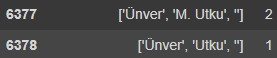
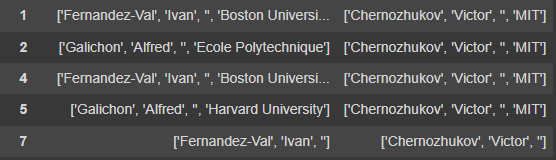

In [ ]:
# The 3rd string indicates organization so we should just delete it for network purposes
kaggle_df['authors_parsed'] = kaggle_df.authors_parsed.apply(lambda x: [author[0:2] for author in x])

In [ ]:
# Split the categories column into category and subcategory
kaggle_df

,categories,authors_parsed,id
0,hep-ph,"[[Balázs, C.], [Berger, E. L.], [Nadolsky, P. ...",704.0001
1,math.CO cs.CG,"[[Streinu, Ileana], [Theran, Louis]]",704.0002
2,physics.gen-ph,"[[Pan, Hongjun]]",704.0003
3,math.CO,"[[Callan, David]]",704.0004
4,math.CA math.FA,"[[Abu-Shammala, Wael], [Torchinsky, Alberto]]",704.0005
...,...,...,...
74791,supr-con cond-mat.supr-con,"[[Prozorov, R.], [Konczykowski, M.], [Schmidt,...",supr-con/9608008
74792,supr-con cond-mat.supr-con,"[[Choudhury, Durga P.], [Willemsen, Balam A.],...",supr-con/9609001
74793,supr-con cond-mat.supr-con,"[[Willemsen, Balam A.], [Derov, J. S.], [Sridh...",supr-con/9609002
74794,supr-con cond-mat.supr-con,"[[Hasegawa, Yasumasa]]",supr-con/9609003


We need to summarise the data from the kaggle_df in order to filter the S2ORC dataset explained later on. Thus, pickle and save either sets of dictionaries (for constant time lookup) to be used later.

In [ ]:
%%script echo skipping
import pickle
import re

RE_PATTERN = re.compile(r'\s+')

def normalise_text(text: str) -> str:
    return re.sub(RE_PATTERN, ' ', text.lower()).strip()

all_id_set = set(kaggle_df['id'].apply(str))
if None in all_id_set:
  all_id_set.remove(None)
with open("/content/drive/MyDrive/all-id-set", "wb") as f:
  pickle.dump(all_id_set, f)

all_doi_dict = {
    row['doi']: str(row['id'])
    for _, row in kaggle_df.iterrows()
    if row['doi'] is not None
}
with open("/content/drive/MyDrive/all-doi-dict", "wb") as f:
  pickle.dump(all_doi_dict, f)

all_venue_dict = {
    normalise_text(row['journal-ref']): str(row['id'])
    for _, row in kaggle_df.iterrows()
    if row['journal-ref'] is not None
}
with open("/content/drive/MyDrive/all-venue-dict", "wb") as f:
  pickle.dump(all_venue_dict, f)

all_title_dict = {
    normalise_text(row['title']): str(row['id'])
    for _, row in kaggle_df.iterrows()
    if row['title'] is not None
}
with open("/content/drive/MyDrive/all-title-dict", "wb") as f:
  pickle.dump(all_title_dict, f)

all_abstract_dict = {
    normalise_text(row['abstract']): str(row['id'])
    for _, row in kaggle_df.iterrows()
    if row['abstract'] is not None
}
with open("/content/drive/MyDrive/all-abstract-dict", "wb") as f:
  pickle.dump(all_abstract_dict, f)

skipping


In [ ]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


In [ ]:
%%script echo skipping
!cp all-abstract-dict /content/drive/MyDrive
!cp all-doi-dict /content/drive/MyDrive
!cp all-title-dict /content/drive/MyDrive
!cp all-venue-dict /content/drive/MyDrive

skipping


### Additional data collection

We talk here about s2orc, we show the code where we transformed it and downloaded the data, preface all cells with `%%script echo skipping` to indicate they will not be run, we explain our intentions of creating a reference network, and state that it would be possible with the large dataset.



---


## *Data analysis*


### Categories
Papers in arXiv are divided into categories. Papers can belong to more than one category and categories can have multiple sub-categories.

*What categories are present in the database, how about subcategories?*

In [ ]:
# In kaggle_df.categories, multiple categories are separated by spaces
subcategories_df = kaggle_df  \
  .categories.apply(lambda x: set(x.split(' '))).explode().to_frame().reset_index() \
  .groupby(by='categories', as_index=False).count()  \
  .rename(columns={'index':'amount','categories':'subcategory'})

# Subcategories are written as [category].[subcategory]
subcategories_df['category'] = subcategories_df.subcategory.apply(lambda x: x.split('.')[0])

In [ ]:
# Categories cannot be extracted by subcategory, as a paper can belong to several subcategories of the same category
# If not corrected, this would warp results to favour categories with a higher amount of sub-categories
def get_categories(categories):
  return set([category.split('.')[0] for category in categories.split(' ')])

categories_df = kaggle_df.categories.apply(get_categories) \
  .explode().to_frame().reset_index().groupby(by='categories', as_index=False).count() \
  .reset_index(drop=True).rename(columns={'categories':'category','index':'amount'})

*We can plot categories to visualize the distribution of papers, and locate categories with the greatest amount*

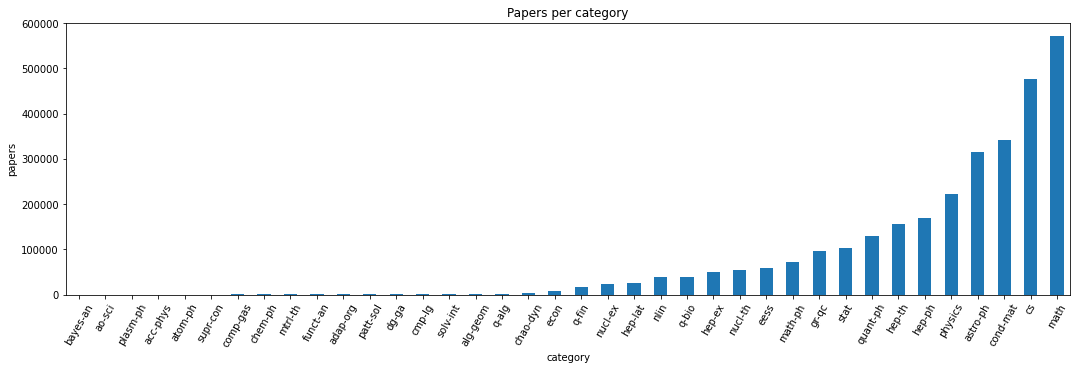

In [ ]:
# We can plot a bar chart to visualize each category
categories_df.set_index('category').sort_values(by='amount').plot(kind='bar',figsize=(18,5), title='Papers per category',legend=False,ylabel='papers')
plt.xticks(rotation = 60)
plt.show()

*Since there are hundreds of subcategories, we will choose to visualize only those with the highest amount of papers*

In [ ]:
SIZE = 14

In [ ]:
# First it is necessary to isolate the [SIZE] largest categories by paper amount
top_categories_df = categories_df.sort_values(by='amount',ascending=False).reset_index(drop=True) \
                      .head(SIZE).rename(columns={'amount':'category_amount'})

In [ ]:
# The graph will distinguish subcategories in different categories by color
palette = sns.color_palette(None, SIZE)
x_colors = {}
for i in range(SIZE):
  x_colors[top_categories_df.iloc[i,0]] =  palette[i]

In [ ]:
# We join the top categories to get all subcategories
plot_df_ = subcategories_df.merge(top_categories_df,how='right')
# We want to order subcategories by size, and categories by size of largest subcategory
# for this we groupby the maximun for each category and then join with the table
plot_df_ = plot_df_.merge( \
                  plot_df_[['category','amount']].groupby(by='category', as_index=False).max(), \
                  left_on='category',right_on='category',how='inner') \
                  .sort_values(by=['amount_y','amount_x'])[['category','subcategory','amount_x']] \
                  .rename(columns={'amount_x':'amount'})

<ipython-input-25-09b2f9a3b9eb>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().axes.get_xaxis().set_visible(False)


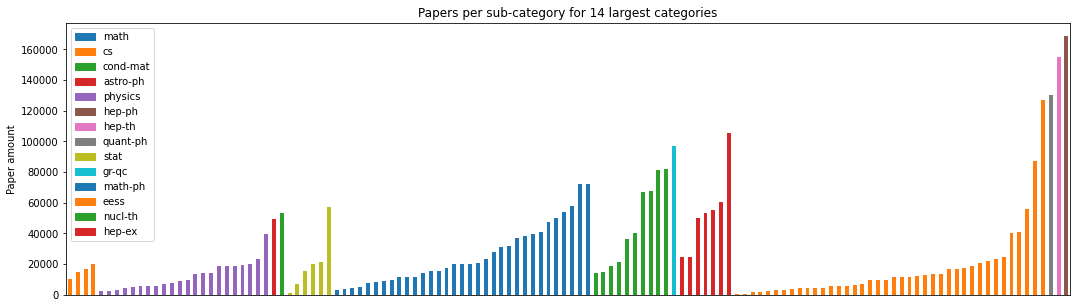

In [ ]:
# With all dataframes colleted we can plot subcategories
plot_df_.plot(figsize=(18,5),legend=True,title='Papers per sub-category for '+str(SIZE)+' largest categories',kind='bar',y='amount',x='subcategory', ylabel='Paper amount',xlabel='Category',color=[x_colors[i.split('.')[0]] for i in plot_df_.subcategory])
plt.axes().axes.get_xaxis().set_visible(False)
plt.legend([mpatches.Patch(color=x_colors[i]) for i in x_colors], [i for i in x_colors])
plt.show()

*We can plot a heatmap of the shared papers between the categories with the highest amounts of papers*

In [ ]:
# We explode the kaggle dataframe by category to easily find papers with a certain category
kaggle_exploded_ = kaggle_df['categories'] \
                      .apply(lambda x: [category.split('.')[0] for category in x.split(' ')]) \
                      .reset_index(drop=True).explode().to_frame().reset_index()

# kaggle_categories counts the amount of papers belonging to an array of categories
def kaggle_categories(categories):
  return  kaggle_exploded_[kaggle_exploded_.categories.isin(categories)].groupby(by='index').first().shape[0]

In [ ]:
# In order to find correlation, we will count how many papers each category contains
p_in_category_ = pd.concat([top_categories_df['category'],top_categories_df['category'].apply(lambda x: kaggle_categories([x]))],axis=1)
p_in_category_.columns = ['category','amount']

# Then we combine each category with all other categories to form a matrix
correlation_df = pd.DataFrame(list(product(top_categories_df['category'], top_categories_df['category']))).rename(columns={0:'first',1:'second'}) \
                    .merge(p_in_category_, how='inner',left_on='first',right_on='category').rename(columns={'amount':'first_amount'}) \
                    .merge(p_in_category_, how='inner',left_on='second',right_on='category').rename(columns={'amount':'second_amount'}) \
                    [['first','second','first_amount','second_amount']]

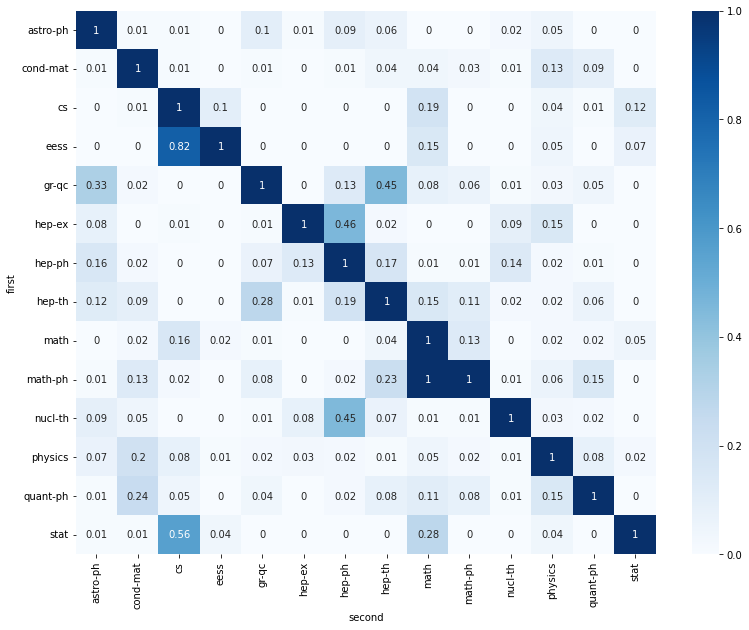

In [ ]:
# In order to find what papers 2 categories have in common, we search through the kaggle dataframe once more
correlation_df['both_amount'] = correlation_df.apply(lambda x: kaggle_categories([x['first'], x['second']]),axis=1)

# By subtracting the result from the sum of the individual amount for each category, we arrive at the shared papers
correlation_df['shared'] = (correlation_df['first_amount'] + correlation_df['second_amount']) - correlation_df['both_amount']

# With this we can now calculate correlation
correlation_df['corr'] = round(correlation_df['shared'] / correlation_df['first_amount'],2)

# Before plotting, we must pivot the table into a matrix
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(correlation_df[['first','second','corr']].pivot_table('corr', 'first', 'second'), cmap="Blues", annot=True, ax=ax)

*In order to reduce computational intensity, it is necessary to focus on a limited amount of categories, it is to be expected that interconectivity between a given category will be higher than between categories*

In [ ]:
FOCUSED_CATEGORIES = ['econ']

### Authors
Our main focus of analysis will be on the authors of the papers and the relationships between them

*Starting from the categories of focus chosen in the categories section, authors_df is created for all future author analysis*

In [ ]:
# From kaggle, take categories and authors_parsed
authors_df = kaggle_df[['categories','authors_parsed']]

# Modify categories to isolate FOCUSED_CATEGORIES and remove any others
authors_df.categories = authors_df.categories.apply(lambda x: \
  [category.split('.')[0] for category in x.split(' ')]) \
  .apply(lambda x: list(set([elem for elem in x if elem in FOCUSED_CATEGORIES])))

# Remove rows in kaggle with none of FOCUSED_CATEGORIES
authors_df = authors_df[authors_df.categories.apply(lambda x: len(x)) > 0]

# Explode authors by group in order to have easy access to individual authors
authors_df = authors_df.reset_index(drop=True) \
  .reset_index().explode('authors_parsed') \
  .rename(columns={'authors_parsed':'author','index':'group'})[['author','group']]

# Convert the array identifying each author to string for ease of access
authors_df['author'] = authors_df['author'].astype('string')

print('Papers in category: '+str(authors_df.shape[0]))

Papers in category: 17536


*Before running analysis on the network of authors, it can be benefitial to understand the distributions of papers and authors*

In [ ]:
papers_per_author_df = authors_df.groupby(by='author', as_index=False).count().groupby(by='group',as_index=False).count()
authors_per_paper_df = authors_df.groupby(by='group', as_index=False).count().groupby(by='author',as_index=False).count()

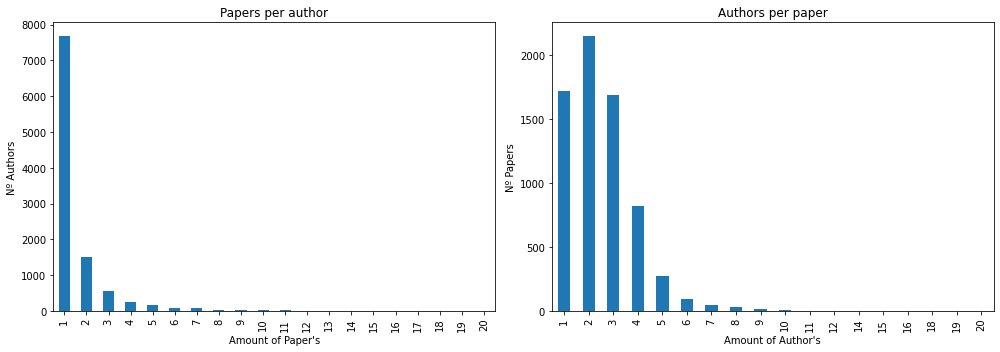

In [ ]:
# Plotting papers_per_author_df and authors_per_paper_df
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

papers_per_author_df[papers_per_author_df.group <= 20].set_index('group') \
  .plot(kind='bar', title='Papers per author', ylabel='Nº Authors',xlabel='Amount of Paper\'s',legend=False, ax=axes[0])
authors_per_paper_df[authors_per_paper_df.author <= 20].set_index('author') \
  .plot(kind='bar',title='Authors per paper', ylabel='Nº Papers',xlabel='Amount of Author\'s',legend=False, ax=axes[1])

fig.tight_layout()
plt.show()

*In order to create a network, we extract information from the list of authors in every paper. It is standard that the main author's name be the first in the authors of a paper, so other authors in the list will of have contributed to the main author's paper. From this we can build a network where all authors except the first in the list have a directional connection to the first in the list.*

In [ ]:
# main_contributor_df contains the main reasercher for each paper
main_contributor_df = authors_df.groupby(by='group',as_index=False).first().drop_duplicates()
# network_df connects each author to any main reaserchers they have worked with
network_df = authors_df.merge(main_contributor_df, left_on='group', right_on='group') \
  .rename(columns={'author_x':'from','author_y':'to'})[['from','to']]

network_df = network_df[network_df['from'] != network_df['to']].drop_duplicates()
# reaserchers_df is the list of reaserchers in the database
reaserchers_df = authors_df[['author']].drop_duplicates()

### Author relationships
Analysing relationships between authors allows us to understand the network and decide on the best graph algorithms to run on it.

Nodes in a network are connected by edges, in our application these connections represent all the information we are trying to analyse.

It is beneficial to get a sense of the conectivity of the graph (we have implemented a visualizer tool, but the graph is too large to gain any real insight).

A good starting point is analysing sinks (nodes with no outgoing edges) and sources (nodes with no incoming edges).

*   _Sinks_ are authors that are the main author on all of their rpapers
*   _Sources_ are authors that are not the main author on any of their papers
*   We call _Connected_ authors those who have papers in which they are main authors and papers in which they are secondary authors

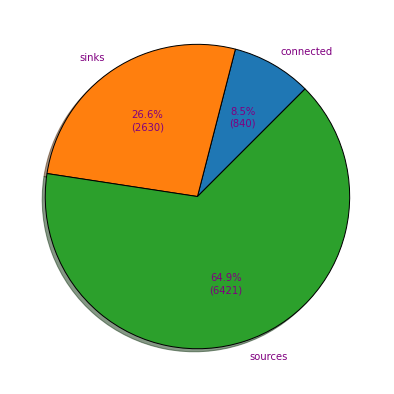

In [ ]:
# In the network, certain nodes have special properties
def network_sections(net_df):
  merge_ = net_df[['from']].drop_duplicates().merge(net_df[['to']].drop_duplicates(), how='outer', indicator=True,left_on='from',right_on='to')

  # sources do not appear in the to column
  sources_df = merge_[merge_._merge == 'left_only'][['from']].rename(columns={'from':'author'}).drop_duplicates()
  # sinks do not appear in the from column
  sinks_df = merge_[merge_._merge == 'right_only'][['to']].rename(columns={'to':'author'}).drop_duplicates()
  # connected appear in both from and to column
  connected_df = merge_[merge_._merge == 'both'][['from']].rename(columns={'from':'author'}).drop_duplicates()

  return [sources_df, sinks_df, connected_df]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wp = { 'linewidth' : 1, 'edgecolor' : "black" }
sources_df, sinks_df, connected_df = network_sections(network_df)
data = [connected_df.shape[0], sinks_df.shape[0], sources_df.shape[0]]
plt.figure(figsize=(7,7))
plt.pie(data, labels = ['connected', 'sinks', 'sources'], autopct = lambda pct: func(pct, data),startangle=45, wedgeprops = wp, shadow = True, textprops = dict(color ="purple"))
plt.show()

Let's make sure we have full coverage of the graph with these 3 categories

In [ ]:
# No author in the network can be 2 of source/sink/connected simultaneously
assert sources_df.merge(sinks_df, how='inner').shape[0] == 0
assert sinks_df.merge(connected_df, how='inner').shape[0] == 0
assert sources_df.merge(connected_df, how='inner').shape[0] == 0

Some papers will be published by a single author, papers with a single author do not have an effect over the network, as they convey no information about author relationships

In [ ]:
# If the group size of the paper is 1, there is only 1 author
group_sizes_df = authors_df.groupby(by='group', as_index=False).count().rename(columns={'author':'count'})
single_points_df = authors_df.merge( \
  group_sizes_df[group_sizes_df['count'] == 1][['group']].drop_duplicates(), \
  how='inner',left_on='group',right_on='group')[['group']].drop_duplicates()
print('Papers with a single author listed in publication: '+str(single_points_df.shape[0])+', this is ' +str(100*round(single_points_df.shape[0]/main_contributor_df.shape[0],2))+ '% of papers')

Papers with a single author listed in publication: 1714, this is 25.0% of papers


Some authors will only have single-author papers published, these are not even included in the network

In [ ]:
# We can observe single-author-paper-authors by simply counting how many authors are not in the network
merge_ = reaserchers_df.merge(sources_df,how='outer',indicator=True)
merge_ = merge_[merge_._merge == 'left_only'][['author']]
merge_ = merge_.merge(sinks_df,how='outer',indicator=True)
merge_ = merge_[merge_._merge == 'left_only'][['author']]
merge_ = merge_.merge(connected_df,how='outer',indicator=True)
merge_ = merge_[merge_._merge == 'left_only'][['author']]
single_papers_df = merge_
print('Authors excluded from the network: '+ str(single_papers_df.shape[0]) + ', this is '+str(100*round(single_papers_df.shape[0]/reaserchers_df.shape[0],2))+'% of authors')

Authors excluded from the network: 646, this is 6.0% of authors


We can analyse the graph further by introducing a new type of node to the graph.

We imagine an author network where there are two connected components, this characteristic is important, as conectivity has an effect on our analysis.

If we now imagine a _sink_ type node that connects to both of these components, this graph is now a single connected component, which changes our view of the graph.

If this _sink_ node has only one outgoing edge, it does not influence graph connectivity in any manner. We can call this a _single-sink_. The same rule applies to _single-source_.

We can analyse the true connectivity of our graph by removing these _single-sinks_ and _single-sources_.

In [ ]:
# We find single sinks/sources by filtering sinks as those with an item count of 1
def singles(network, nodes, join_col):
  node_count_ = nodes.merge(network, how='inner',left_on='author',right_on=join_col).groupby(by=join_col,as_index=False).count()
  return node_count_[node_count_.author == 1].drop_duplicates()[[join_col]].rename(columns={join_col:'author'})

sour_, sin_, _ = network_sections(network_df)
print('single-source authors in network: '+ str(singles(network_df, sour_, 'from').shape[0]) +', this is '+str(100*round(singles(network_df, sour_, 'from').shape[0]/reaserchers_df.shape[0],2))+'% of all authors')
print('single-sink authors in network: '+ str(singles(network_df, sin_, 'to').shape[0])+', this is '+str(100*round(singles(network_df, sin_, 'to').shape[0]/reaserchers_df.shape[0],2))+'% of all authors')

single-source authors in network: 5643, this is 54.0% of all authors
single-sink authors in network: 927, this is 9.0% of all authors


For the smaller categories, like the chosen example of
`['econ']`,
More than half of the graph yields us little information, as it is only of the _single-type_ which do not increase connectivity.

This is not accounting for _single-type_ nodes that lead into _single-entry:single-exit_ nodes, forming a chain that can be abstracted as a single _single-type_ node.

We can peel back these layers of _single-type_ nodes, we will eventually arrive at the real size of our network in complexity


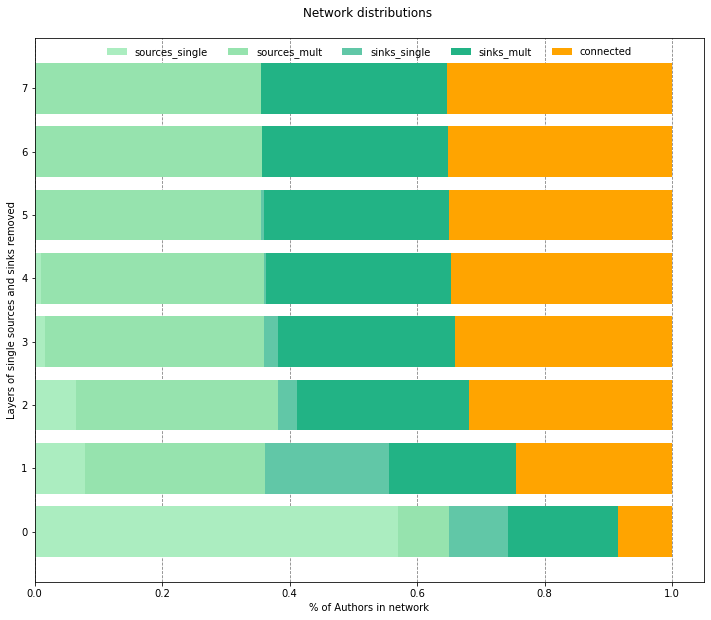

In [ ]:
# We will iterate over a range, for each iteration we will remove all single-type nodes and check the distribution of the network
sour_, sin_, conn_ = network_sections(network_df)
network_iter_ = network_df
proportions_df = pd.DataFrame(columns=['sources_single','sources_mult','sinks_single','sinks_mult','connected'])
for i in range(8):
  # Obtaining single-sink nodes
  sour_sing_ = singles(network_iter_, sour_, 'from').shape[0]
  # Obtaining single-source nodes
  sin_sing_ = singles(network_iter_, sin_, 'to').shape[0]
  # Proportions will save the % distributions of the node-types for each iteration
  proportions_df.loc[i] = [sour_sing_, sour_.shape[0] - sour_sing_, sin_sing_, sin_.shape[0] - sin_sing_, conn_.shape[0]]
  proportions_df.loc[i] = proportions_df.loc[i] / proportions_df.loc[i].sum()
  # Collect single-type nodes for removal
  authors_removed_df = pd.concat([singles(network_iter_, sour_, 'from'), singles(network_iter_, sin_, 'to')], axis=0)
  # Remove single-type nodes from network, for next iteration
  network_iter_ = network_iter_[ \
    ~network_iter_['from'].isin(authors_removed_df.author.to_list()) * \
    ~network_iter_['to'].isin(authors_removed_df.author.to_list())]
  # Calculate sections for next iteration
  sour_, sin_, conn_ = network_sections(network_iter_)

colors = ['#ABEDC0', '#96E3AE', '#61C7A7', '#22B385', '#FFA400', '#4C5B5C']

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(proportions_df) * [0]
for idx, name in enumerate(proportions_df.columns):
    plt.barh(proportions_df.index, proportions_df[name], left = left, color=colors[idx])
    left = left + proportions_df[name]
# title, legend, labels
plt.title('Network distributions \n', loc='center')
plt.legend(proportions_df.columns, ncol=5, frameon=False, loc='upper center')
plt.xlabel('% of Authors in network')
plt.ylabel('Layers of single sources and sinks removed')
# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In our actual information pipeline, we load our graph into spark and run our analysis over the entire thing. If we where optimizing for efficiency, we would trim down the network to this size to reduce it's size; **the reductions would be ~70% of nodes!!!**

For our initial analysis section, we will not be using spark. With a non-distributed implementation a full network size, even for our chosen `['econ']` category, would significantly slow down our computations.

To speed things up we will trim out _single-type_ nodes for in our analysis section, even if they will be present in the modelling section.

In [ ]:
# Collect single type nodes
sour_, sin_, _ = network_sections(network_df)
authors_removed_df = pd.concat([singles(network_df, sour_, 'from'), singles(network_df, sin_, 'to')], axis=0)
# Remove them from the network
network_df = network_df[~network_df['from'].isin(authors_removed_df.author.to_list()) * ~network_df['to'].isin(authors_removed_df.author.to_list())]
print('Removed '+str(round(100.0 * authors_removed_df.shape[0]/reaserchers_df.shape[0],2))+'% of the authors in network')

Removed 62.34% of the authors in network


The last part of our analysis for the author graph will be **connected components**!

Analysing the conectivity of the graph is very important, a low connectivity can mean our data is too sparse, or the relationship we are trying to graph is not reflected in the data.

In [ ]:
# Nodes can be from both origin and destination
nodes_df = network_df[['from']].merge(network_df[['to']].rename(columns={'to':'from'}), how='outer', left_on='from', right_on='from').drop_duplicates()
# Initially, the algorith starts with all nodes in a different group
groups_df = nodes_df.reset_index(drop=True).reset_index().rename(columns={'from':'author', 'index':'group'})[['author','group']]

We will use a group algorithm, where every node looks at neighbouring nodes and compares it's group number, if the recieved group number is larger, the node adopts that number. When no nodes have changed from one iteration to the next, the algorithm has finished.

In [ ]:
# groups (node groupings by connected)
groups_df.rename(columns={'group':'ngroup'}).to_sql("groups", conn, if_exists="replace", index=False)
# inner_network (link descriptors)
network_df.rename(columns={'from':'nfrom', 'to':'nto'}).to_sql("inner_network", conn, if_exists="replace", index=False)

# finished_groups (nodes that have already reached a max grouping) starts as empty
groups_df[groups_df.group == -1].to_sql('finished_groups', conn, if_exists='replace', index=False)

iter = 0
rank_change = -1

while iter < 100 and rank_change != 0:
  sql_commands = []
  # save last groups
  sql_commands.append(['SELECT * FROM groups', 'last_groups'])
  # join groups with inner_network for comparison on both back links and front links
  sql_commands.append(['''
                        SELECT g1.author, MAX((
                                SELECT IFNULL(MAX((SELECT g4.ngroup FROM groups g4 WHERE g4.author = n2.nfrom)),-1)
                                FROM groups g3
                                LEFT JOIN inner_network n2
                                ON g3.author = n2.nto
                                WHERE g3.author = g1.author),
                            g1.ngroup, (
                                SELECT IFNULL(MAX((SELECT g4.ngroup FROM groups g4 WHERE g4.author = n1.nto)),-1)
                                FROM groups g2
                                LEFT JOIN inner_network n1
                                ON g2.author = n1.nfrom
                                WHERE g2.author = g1.author)) AS ngroup
                        FROM groups g1
                  ''','groups', False])
  # run the queries
  for command in sql_commands:
    run_query(command[0], command[1], debug=(False if len(command)==2 else command[2]))

  # Check if network has had no change, meaning all groups have been found
  rank_change = pd.read_sql_query('''SELECT COUNT(ABS(last.ngroup - curr.ngroup))
                          FROM groups curr
                          JOIN last_groups last
                          ON curr.author = last.author
                          WHERE ABS(last.ngroup - curr.ngroup) > 0''', conn).iloc[0,0]
  iter += 1
  print('NODES UPDATED: '+str(rank_change))

groups_df = pd.read_sql_query('SELECT * FROM groups', conn).rename(columns={'ngroup':'group'})

NODES UPDATED: 1391
NODES UPDATED: 1013
NODES UPDATED: 762
NODES UPDATED: 659
NODES UPDATED: 637
NODES UPDATED: 558
NODES UPDATED: 542
NODES UPDATED: 499
NODES UPDATED: 395
NODES UPDATED: 339
NODES UPDATED: 343
NODES UPDATED: 344
NODES UPDATED: 290
NODES UPDATED: 281
NODES UPDATED: 207
NODES UPDATED: 166
NODES UPDATED: 140
NODES UPDATED: 87
NODES UPDATED: 49
NODES UPDATED: 33
NODES UPDATED: 15
NODES UPDATED: 7
NODES UPDATED: 9
NODES UPDATED: 2
NODES UPDATED: 2
NODES UPDATED: 1
NODES UPDATED: 1
NODES UPDATED: 0


We now have connected components!

We can show some visualizations about their distributions.

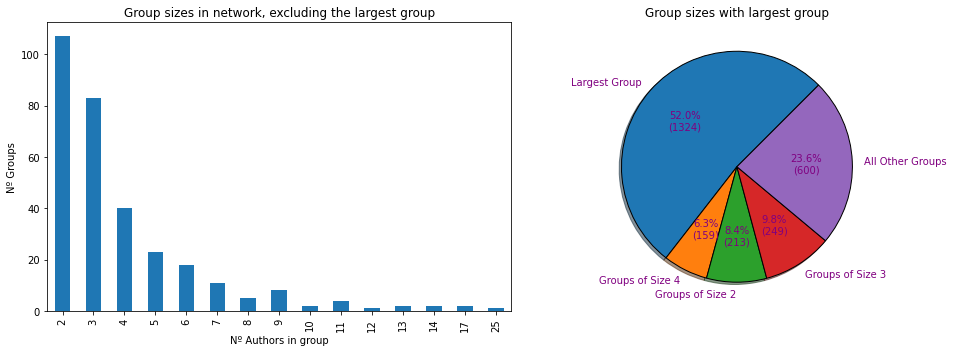

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

authors_per_group_df = groups_df.groupby(by='group',as_index=False).count().groupby(by='author',as_index=False).count()

authors_per_group_df.set_index('author').iloc[:-1,:] \
  .plot(kind='bar',title='Group sizes in network, excluding the largest group', ylabel='Nº Groups',xlabel='Nº Authors in group',legend=False, ax=axes[0])

authors_per_group_df['total'] = authors_per_group_df.author * authors_per_group_df.group

data = [authors_per_group_df.iloc[-1,0]]
labels = ['Largest Group']
pie_slices = 4
for row in authors_per_group_df.sort_values(by='total').iloc[-pie_slices:-1,:].values.tolist():
  data.append(row[2])
  labels.append('Groups of Size '+str(row[0]))

data.append(authors_per_group_df.sort_values(by='total').iloc[:-pie_slices,:].total.sum())
labels.append('All Other Groups')
axes[1].pie(data, labels=labels, autopct = lambda pct: func(pct, data),startangle=45, wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black" }, shadow = True, textprops = dict(color ="purple"))
axes[1].set_title('Group sizes with largest group')

fig.tight_layout()
plt.show()

This shows our `['econ']` network is not too good. The largest group contains the absolute majority of nodes, but against the network it has only slightly above 50% coverage of nodes.

The good news is that this distribution changes as networks get larger! We have chosen `['econ']` for our exploratory analysis because it is very small, but by analysing `['stat']` which is only slightly larger (3x more papers) in comparison to the larger categories like `['cs']`, we get a >95% coverage of nodes by the largest group!!!

We now have a reasonably sized group, small enough that we can visualize the entire thing in a computer screen at a reasonable size. We can generate an html file that will show the network in it's entirety (and allow mouse navigation, zoom, and nudging nodes around to visualize conectivity!!!)

In [ ]:
# Print the size of the network in nodes
print('largest group nodes: ' + str(groups_df.groupby(by='group', as_index=False).count().sort_values(by='author', ascending=False).reset_index(drop=True).iloc[0,1]))
# Call the visualize function (declared at the start of the notebook) to generate a visualization of the largest group
largest_group_df = groups_df[groups_df.group == groups_df.groupby(by='group', as_index=False).count().sort_values(by='author', ascending=False).reset_index(drop=True).iloc[0,0]][['author']].merge(network_df,how='inner',left_on='author',right_on='from')[['from','to']].drop_duplicates()
visualize_df(largest_group_df, source= 'from', target='to', name='largest_group')

largest group nodes: 1325
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
To see graph, click on files on left side -> right click on graph.htm -> download -> open the file in your browser


### Author importance
In order to extract popularity from author information, we run a PageRank over the author network

In [ ]:
from IPython.display import clear_output
# social rank (rating value size n)
largest_group_df[['from']].drop_duplicates().assign(rank=1.0).rename(columns={'from':'nfrom'}).to_sql("social_rank", conn, if_exists="replace", index=False)
# occurances (static node amounts size n)
largest_group_df.groupby(by='from',as_index=False).count().rename(columns={'from':'nfrom','to':'freq'}).to_sql("occurances", conn, if_exists="replace", index=False)
# network (link descriptors size l>n)
largest_group_df.rename(columns={'from':'nfrom', 'to':'nto'}).to_sql("network", conn, if_exists="replace", index=False)
# decay hyperparameter
decay = 0.15
decay_formula = ''+str(decay)+'+'+str(1-decay)
# stopping conditions
min_rank_change = 0.001
max_iter = 100

rank_change = min_rank_change + 0.1
iter = 0

while rank_change > min_rank_change and iter < max_iter:
  sql_commands = []
  # save last social_rank
  sql_commands.append(['SELECT * FROM social_rank', 'last_social_rank'])
  # social rank join occurances, divide rank by occurances [nfrom, rank/freq=rank_div]
  sql_commands.append(['''SELECT DISTINCT sr.nfrom, rank/freq AS rank_div
                          FROM social_rank sr
                          JOIN occurances o
                          ON sr.nfrom = o.nfrom''','rank_to_give'])
  # join with network on nfrom, keep destination and amount, groupby destination with decay [nto, decay-(1-decay)*SUM(rank_div)]
  sql_commands.append(['''SELECT nto AS nfrom, '''+decay_formula+''' * SUM(rank_div) AS rank
                          FROM rank_to_give r
                          JOIN network n
                          ON r.nfrom = n.nfrom
                          GROUP BY nto''','social_rank'])
  # run the queries
  for command in sql_commands:
    run_query(command[0], command[1], debug=(False if len(command)==2 else command[2]), limit=8)

  # Obtain highest change in rank --> join last_social_rank with social_rank calculating the difference in rank, and get the maximun
  rank_change = pd.read_sql_query('''SELECT ABS(last.rank - curr.rank) AS rank_change
                          FROM social_rank curr
                          JOIN last_social_rank last
                          ON curr.nfrom = last.nfrom
                          ORDER BY rank_change DESC''', conn).iloc[0,0]
  iter += 1
  clear_output(wait=True)
  print('MAX RANK CHANGE: '+str(rank_change)+'\nITERATION: '+str(iter))

social_rank_df = pd.read_sql_query('SELECT * FROM social_rank', conn).rename(columns={'nfrom':'from'})
# Add sources as nodes with 0 rank
social_rank_df = largest_group_df[['from']].drop_duplicates().merge(social_rank_df, how='outer').fillna(0)

MAX RANK CHANGE: 0.0009865702167752843
ITERATION: 48


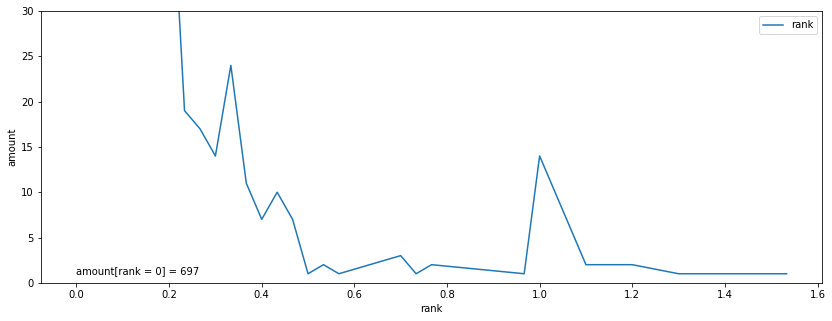

In [ ]:
# We can visualize the resulting ranking distribution
granularity = 30
y_size = 30
pd.DataFrame(((social_rank_df['rank']*granularity).round(0)/granularity).value_counts()).reset_index().sort_values(by='index',ascending=False).plot(x='index', y='rank',ylabel='amount',xlabel='rank', ylim=(0,y_size), figsize=(14, 5))
plt.text(0, 1, 'amount[rank = 0] = '+str(((social_rank_df['rank']*granularity).round(0)/granularity).value_counts()[0]))
plt.show()

In [ ]:
# Winner of the social rank!
social_rank_df.sort_values(by='rank').iloc[-1,0]

"['Graham', 'Bryan S.']"

### Paper relationships attempt 1

In order to figure out what papers were most important, we needed to find the inbound citations for each paper within the kaggle dataset. There were 2 main options for doing this:
- Scrape a site such as Google scholar (among others).
- Find a previously made dataset that contains the citations within the kaggle dataset.

We attempted to scrape websites such as Google scholar (see code in the graveyard), but were only able to sample at about 1 paper per second (much too slow. Further, the sites would block our IP address each time, so this wasn't a feasible method.

We found the below dataset from the paper https://arxiv.org/abs/1905.00075, which contains *exactly* what we needed (i.e., a citation graph) made in 2019.

In [ ]:
import requests

# Download zipped dataset
URL = "https://github.com/mattbierbaum/arxiv-public-datasets/releases/download/v0.2.0/internal-references-v0.2.0-2019-03-01.json.gz"
with open("citations-graph.json.gz", "wb") as f:
  f.write(requests.get(URL).content)

In [ ]:
# Unzip
!gzip -d citations-graph.json.gz

In [ ]:
# Load data into a dataframe
import json
import pandas as pd

with open("citations-graph.json", "r") as f:
  citation_graph = json.loads(f.read())

citation_graph = [(v, w) for (v, ws) in citation_graph.items() for w in ws]

citation_graph_df = pd.DataFrame(citation_graph).rename(columns={0: 'from', 1: 'to'})
citation_graph_df

,from,to
0,alg-geom/9412010,alg-geom/9509005
1,alg-geom/9412020,alg-geom/9505009
2,alg-geom/9412012,alg-geom/9407002
3,alg-geom/9412017,alg-geom/9411005
4,alg-geom/9412017,alg-geom/9310001
...,...,...
6849628,hep-lat/0004009,hep-lat/0002004
6849629,hep-lat/0004009,hep-lat/9907024
6849630,hep-lat/0004009,hep-lat/0004002
6849631,hep-lat/0004009,hep-lat/9907028


Repackage the data and merge with the kaggle dataframe. This is to check what proportion of papers in the kaggle dataframe we have in the citation graph.

In [ ]:
citation_graph_nodes = pd.concat((citation_graph_df['from'], citation_graph_df['to'])).drop_duplicates().to_frame().rename(columns={0: 'vertex'})
citation_graph_nodes = citation_graph_nodes.merge(kaggle_df, how='outer', left_on='vertex', right_on='id', indicator=True)[['vertex', 'id', 'categories', '_merge']]
citation_graph_nodes

,vertex,id,categories,_merge
0,alg-geom/9412010,alg-geom/9412010,alg-geom math.AG,both
1,alg-geom/9412020,alg-geom/9412020,alg-geom math.AG,both
2,alg-geom/9412012,alg-geom/9412012,alg-geom dg-ga math.AG math.DG,both
3,alg-geom/9412017,alg-geom/9412017,alg-geom hep-th math.AG,both
4,alg-geom/9504006,alg-geom/9504006,alg-geom math.AG,both
...,...,...,...,...
2862969,NaN,supr-con/9608008,supr-con cond-mat.supr-con,right_only
2862970,NaN,supr-con/9609001,supr-con cond-mat.supr-con,right_only
2862971,NaN,supr-con/9609002,supr-con cond-mat.supr-con,right_only
2862972,NaN,supr-con/9609003,supr-con cond-mat.supr-con,right_only


In [ ]:
kaggle_present_df = citation_graph_nodes[citation_graph_nodes['_merge'] == 'both'][['id','categories']]
kaggle_present_df.categories = kaggle_present_df.categories.apply(get_categories)
kaggle_present_df = kaggle_present_df.set_index('id').categories.explode().to_frame().reset_index()
kaggle_present_df = kaggle_present_df.groupby('categories', as_index=False).count().merge(categories_df, left_on='categories', right_on='category')[['category', 'id', 'amount']]
kaggle_present_df['ratio'] = 100 * kaggle_present_df.id / kaggle_present_df.amount
kaggle_present_df.sort_values('ratio', ascending=False)

,category,id,amount,ratio
30,q-alg,1314,1578,83.269962
34,solv-int,1085,1413,76.786978
13,dg-ga,457,732,62.431694
2,alg-geom,854,1423,60.014055
6,bayes-an,9,16,56.250000
1,adap-org,292,584,50.000000
15,funct-an,206,427,48.243560
7,chao-dyn,1113,2398,46.413678
5,atom-ph,50,123,40.650407
18,hep-lat,9916,26193,37.857443


For large categories, there only ended up being less 0.3% present in the citation graph. So the dataset is ununsable :(((((((((

### Paper relationships attempt 2

We found a second dataset called [The Semantic Scholar Open Research Corpus](https://github.com/allenai/s2orc) (S2ORC) which has scraped Semantic Scholar for paper information, which includes paper citations. We applied for access to the dataset and they gave us access. The dataset is 800GB, so we must download, filter and process it in batches.

For the sake of speed when filtering, load pre-computed sets of abstracts, dois, ids and titles which'll be used when iterating through to filter and find matches within the S2ORC dataset.

In [ ]:
%%script echo skipping
# Make a set of all arxiv ids that we have to make it expected
# constant time to check if an id is present
import pickle

# Get kaggle abstract dict
with open('/content/drive/MyDrive/all-abstract-dict', 'rb') as f:
  kaggle_abstracts = pickle.load(f)
print('Loaded abstracts')

# Get kaggle doi dict
with open('/content/drive/MyDrive/all-doi-dict', 'rb') as f:
  kaggle_dois = pickle.load(f)
print('Loaded dois')

# Get kaggle id set
with open('/content/drive/MyDrive/all-id-set', 'rb') as f:
  kaggle_ids = pickle.load(f)
print('Loaded ids')

# Get kaggle title set
with open('/content/drive/MyDrive/all-title-dict', 'rb') as f:
  kaggle_titles = pickle.load(f)
print('Loaded titles')

skipping


Imports and easily configurable constants to edit output paths and starting/ending batch numbers.

In [ ]:
%%script echo skipping
import os
import subprocess
import gzip
import io
import json
from tqdm import tqdm
import json
import re

METADATA_INPUT_DIR = 'metadata/raw/'
METADATA_OUTPUT_DIR = '/content/drive/MyDrive/metadata/arxvid_found/'
PDF_PARSES_INPUT_DIR = 'pdf_parses/raw/'
PDF_PARSES_OUTPUT_DIR = '/content/drive/MyDrive/pdf_parses/arxvid_found/'
ID_MAP_BASE_PATH = '/content/drive/MyDrive/id_maps/'

START_BATCH_NUM = 81
END_BATCH_NUM = 99

CONSOLE_LOG_FREQ = 5000

RE_PATTERN = re.compile(r'\s+')

skipping


The following code downloads and filters paper metadata. Note that the basis for this code was supplied to us by the maintainers of S2ORC dataset, although it's been heavily modified to cater to our requirements.

In [ ]:
%%script echo skipping
# process single batch
def process_batch(batch: dict):
  # this downloads both the metadata & full text files for a particular shard
  cmd = ["wget", "-O", batch['input_metadata_path'], batch['input_metadata_url']]
  subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False)

  num_found = 0

  # first, let's filter metadata JSONL to only papers with a particular field of study.
  # we also want to remember which paper IDs to keep, so that we can get their full text later.
  paper_ids_to_keep = set()
  with gzip.open(batch['input_metadata_path'], 'rb') as gz, open(batch['output_metadata_path'], 'wb') as f_out:
    paper_id_to_arxiv_id = {}
    f = io.BufferedReader(gz)
    for line in tqdm(f.readlines()):
      metadata_dict = json.loads(line)
      arxiv_id = None
      if metadata_dict['arxiv_id'] is not None and metadata_dict['arxiv_id'] in kaggle_ids:
        arxiv_id = metadata_dict['arxiv_id']
      elif metadata_dict['doi'] is not None and metadata_dict['doi'] in kaggle_dois:
        arxiv_id = kaggle_dois[metadata_dict['doi']]
      if arxiv_id is None and metadata_dict['title'] is not None:
        try:
          arxiv_id = kaggle_titles[re.sub(RE_PATTERN, ' ', metadata_dict['title'].strip().lower())]
        except KeyError:
          pass
      if arxiv_id is None and metadata_dict['abstract'] is not None:
        try:
          arxiv_id = kaggle_abstracts[re.sub(RE_PATTERN, ' ', metadata_dict['abstract'].strip().lower())]
        except KeyError:
          pass

      if arxiv_id is not None:
        paper_id_to_arxiv_id[metadata_dict['paper_id']] = arxiv_id
        paper_ids_to_keep.add(metadata_dict['paper_id'])
        f_out.write(line)
        num_found += 1
        if num_found % CONSOLE_LOG_FREQ == 0:
          print(f" | {num_found} distinct matches")
  print(f"Total of {num_found} distinct matches in batch {batch['batch_num']}")

  with open(f"{ID_MAP_BASE_PATH}id_map_{batch['batch_num']}", 'w') as f_out:
    json.dump(paper_id_to_arxiv_id, f_out)

  # now delete the raw files to clear up space for other shards
  os.remove(batch['input_metadata_path'])

os.makedirs(METADATA_INPUT_DIR, exist_ok=True)
os.makedirs(METADATA_OUTPUT_DIR, exist_ok=True)
os.makedirs(ID_MAP_BASE_PATH, exist_ok=True)

# there are 100 shards with IDs 0 to 99. make sure these are paired correctly.
download_links = [
  f"https://ai2-s2-s2orc.s3-us-west-2.amazonaws.com/20200705v1/full/metadata/metadata_{batch_num}.jsonl.gz"
  for batch_num in range(START_BATCH_NUM, END_BATCH_NUM + 1)
]

# turn these into batches of work
batches = [{
  'input_metadata_url': download_link,
  'input_metadata_path': os.path.join(METADATA_INPUT_DIR, os.path.basename(download_link.split('?')[0])),
  'output_metadata_path': os.path.join(METADATA_OUTPUT_DIR, os.path.basename(download_link.split('?')[0])),
  'batch_num': START_BATCH_NUM + i,
} for i, download_link in enumerate(download_links)]

for batch in batches:
  process_batch(batch=batch)

skipping


Now that the batches have been filtered and downloaded to the drive, combine them into a single `.jsonl` file. Filter our attributes we don't care about for the sake of time/space.

In [ ]:
%%script echo skipping
# Load in batches
with open(f"{METADATA_OUTPUT_DIR}metadata_combined.json", 'w') as f_out:
  total_papers = 0
  for batch_num in range(100):
    with open(f"{ID_MAP_BASE_PATH}id_map_{batch_num}") as f_in:
      id_map = json.load(f_in)
    total_papers += len(id_map.keys())
    print(f"Batch {batch_num} | {total_papers} total papers")
    with open(f"{METADATA_OUTPUT_DIR}metadata_{batch_num}.jsonl.gz", 'r') as f_in:
      for line in f_in.readlines():
        paper_metadata = json.loads(line)
        paper_metadata['arxiv_id'] = id_map[paper_metadata['paper_id']]
        for field in ('authors', 'abstract', 'acl_id', 'pmc_id', 'pubmed_id', 'doi', 'venue', 's2_url', 'has_inbound_citations', 'has_outbound_citations'):
          paper_metadata.pop(field)

        # Map the citations to our id system
        for citation_list in ('inbound_citations', 'outbound_citations'):
          paper_metadata[f"num_{citation_list}_before"] = len(paper_metadata[citation_list])
          paper_metadata[citation_list] = list(filter(lambda paper_id: paper_id in id_map, paper_metadata[citation_list]))
          paper_metadata[citation_list] = list(map(lambda paper_id: id_map[paper_id], paper_metadata[citation_list]))
          paper_metadata[f"num_{citation_list}"] = len(paper_metadata[citation_list])
        f_out.write(f"{json.dumps(paper_metadata)}\n")

skipping


Example of what each line in the metadata_combined.json file looks like (formatted for readability):
```
{
   "paper_id":"146120525",
   "title":"ARSM: Augment-REINFORCE-Swap-Merge Estimator for Gradient Backpropagation Through Categorical Variables",
   "year":2019,
   "arxiv_id":"1905.01413",
   "journal":"ArXiv",
   "has_pdf_body_text":true,
   "mag_id":"2943262294,2950978196",
   "mag_field_of_study":[
      "Mathematics",
      "Computer Science"
   ],
   "outbound_citations":[
      
   ],
   "inbound_citations":[
      
   ],
   "has_pdf_parse":true,
   "has_pdf_parsed_abstract":true,
   "has_pdf_parsed_body_text":true,
   "has_pdf_parsed_bib_entries":true,
   "has_pdf_parsed_ref_entries":true,
   "num_inbound_citations_before":4,
   "num_inbound_citations":0,
   "num_outbound_citations_before":40,
   "num_outbound_citations":0
}
```

Using the same code as above, the coverage for this dataset is substantially higher at over 70%. This is sufficient for our needs.



---


## *Predictions*


Note that if the notebook is run continuously, the runtime will run out of memory. If this happens, you need to reload the GOOGLE_DRIVE_PATH, dependancies and the kaggle dataset. To do this, please re-run all the first cells marked with a `# *` comment.

The _Predictions_ section does not follow from the information created, parsed, and analysed in the above sections.

As such it is a completely different line of execution and does not share any resources with anything above it, this is by design.

In this section we implement our information pipeline, we minimize unnecessary queries, keep track of the dataframes where our information is contained, and send computationally expensive tasks to a distributed system.

These changes allow us to analyse and make predictions over the biggest categories present in the arxiv dataset. Specifically, we have chosen `'cs'` as an example, although the code will run with any category.

In [ ]:
FOCUSED_CATEGORY = 'cs'

### Feature extraction

#### Initalization

We explain that this is a setup cell because this part of the network is

---

designed to be completely separate from the first part, the past part is about analysis and here we build our pipeline

In [ ]:
#@title
%%capture
!pip install -q kaggle
!pip install pyvis
!pip install networkx

from google.colab import files
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math
from matplotlib import patches as mpatches
from itertools import product
from tqdm import tqdm
from google.colab import drive
import json
import ast
from sklearn.preprocessing import MinMaxScaler

S2ORC_COLS = [
  'title',
  'year',
  'arxiv_id',
  'journal',
  'num_inbound_citations_before',
  'num_outbound_citations_before',
]
arxiv_file = '/content/sample_data/arxiv-metadata-oai-snapshot.json'
s2orc_file = f"/content/drive/MyDrive/{GOOGLE_DRIVE_FILE_PATH}/metadata_combined.jsonl"

# read_line_batch(file_reader, n) reads n amount of lines from file_reader into a dataframe, allowing us to take a chunk of the json file
def read_line_batch(file_reader, n):
  papers = []
  # Iterates through n
  for _ in range(n):
    paper_str = file_reader.readline()[:-1]

    # Stop if we reach the end of file
    if not paper_str:
      print('EOF reached')
      break

    # Add read line to json list
    paper = json.loads(paper_str)
    papers.append(paper)

  return pd.DataFrame(papers)

#### Setup

Arxiv is the beggining of our pipeline, and is in charge of reading both datasets, and preparing the data to be sent to each pipe division

In [ ]:
#@title
class Arxiv:
  def __init__(self, kaggle_file, s2orc_file, category):
    self.kaggle_file = kaggle_file
    self.s2orc_file = s2orc_file
    self.category = category
    self.arxiv_temp = None
    self.s2orc_temp = None
    self.data_df = None
    self.authors_df = None

  def load(self):
    self.arxiv_temp = self.read_kaggle_file()
    self.s2orc_temp = self.read_s2orc_file(self.arxiv_temp['id'])[S2ORC_COLS]
    self.data_df = self.s2orc_temp.merge( \
        self.arxiv_temp[['id','authors_parsed','abstract']], how='inner', left_on='arxiv_id', right_on='id') \
        .drop('arxiv_id', axis=1) \
        .drop_duplicates(subset=['id'])
    self.clean_data()
    return self

  # Read lines from kaggle json with given category
  def read_kaggle_file(self, batch_size = 16411, n_batches = 132):
    file_reader = open(self.kaggle_file, 'r')
    arxiv_temp = pd.DataFrame(columns=['id','authors_parsed', 'title', 'abstract', 'categories', 'journal-ref'])

    for i in tqdm(range(n_batches), desc="Loading kaggle file..."):
      batch = self.isolate_category(read_line_batch(file_reader, batch_size))
      arxiv_temp = pd.concat([arxiv_temp, batch[arxiv_temp.columns]], axis=0)
    arxiv_temp['id'] = arxiv_temp['id'].apply(str)
    return arxiv_temp

  # Modify df_.categories into array and filter for self.category
  def isolate_category(self, df_):
    cat_isolate = lambda cat_list: [cat_full.split('.')[0] for cat_full in cat_list.split(' ')]
    df_['categories'] = df_['categories'].apply(cat_isolate)
    return df_[df_['categories'].apply(lambda x: self.category in x)]

  # Read lines from s2orc present in id_list
  def read_s2orc_file(self, id_list, batch_size = 9547, n_batches = 190):
    file_reader = open(self.s2orc_file, 'r')
    file_reader.readline() #don't ask
    s2orc_df = pd.DataFrame()

    for i in tqdm(range(n_batches), desc="Loading s2orc file... "):
      batch = self.read_line_batch_s2orc(file_reader,batch_size, id_list)
      if s2orc_df.shape[0] == 0: s2orc_df = batch
      else: s2orc_df = pd.concat([s2orc_df, batch], axis=0)

    return s2orc_df

  # Read a batch of lines from the s2orc json file
  def read_line_batch_s2orc(self, file_reader, n, id_list):
    papers = []
    # Iterates through n
    for _ in range(n):
      paper_str = file_reader.readline()[:-1]

      # Stop if we reach the end of file
      if not paper_str:
        print('EOF reached')
        break

      # Add read line to json list
      paper = json.loads(paper_str)
      papers.append(paper)

    df_ = pd.DataFrame(papers)
    df_['arxiv_id'] = df_['arxiv_id'].apply(str)
    return df_.merge(id_list, how='inner', left_on='arxiv_id', right_on='id')

  # Performs several clean operations
  def clean_data(self):
    self.data_df = self.data_df.dropna(subset=['year','authors_parsed','num_inbound_citations_before','abstract'])
    self.data_df['year'] = self.data_df['year'].apply(int)
    self.data_df = self.data_df[(self.data_df.year > 1899) & (self.data_df.year <= 2021)]
    # Remove 3rd term and convert to term to allow comparisons
    arxiv.data_df.authors_parsed = arxiv.data_df.authors_parsed.apply(lambda x: [str(item[0:2]) for item in x])
    # Potentially remove rows with 0 outbound citations, more probable it's just hard to parse
    #arxiv.data_df = arxiv.data_df[~((arxiv.data_df.num_outbound_citations_before == 0) & (arxiv.data_df.num_inbound_citations_before == 0))]
    self.data_df = self.data_df.rename(columns = {'num_inbound_citations_before':'in_citations', 'num_outbound_citations_before':'out_citations'})

    self.data_df.reset_index(drop=True,inplace=True)
    return self

  # Returns the paper distribution by year
  def timeline(self):
    year_dist = self.data_df[['year','id']].groupby(by='year', as_index=False).count()
    return year_dist[(year_dist.year > 1994) & (year_dist.year < 2021)].set_index('year')

  # timeframes returns a dictionary of indices from data_df, each entry corresponding to the year start of a timeframe
  def timeframes(self, start_year, end_year, step_year, frame_year):
    curr_year = start_year
    timeframes = {}

    while (curr_year + frame_year <= end_year):
      timeframes[curr_year] = self.isolate_timeframe(curr_year, curr_year + frame_year).index.values.tolist()
      curr_year = curr_year + step_year

    return timeframes

  # Isolate rows in df published between start and end
  def isolate_timeframe(self, start, end):
    return self.data_df[(self.data_df.year >= start) & (self.data_df.year <= end)]

  # Divide data_df in 3 pieces to prepare for the 3 pipelines
  def split(self):
    return self.data_df[['id', 'authors_parsed']], arxiv.data_df[['id', 'in_citations']], arxiv.data_df[['id','title','abstract']]

In [ ]:
arxiv = Arxiv(arxiv_file, s2orc_file, FOCUSED_CATEGORY)

In `arxiv.load()`, we access both datasets and load them into colab. In order to conserve ram (as neither fits in ram) we load in batches and remove unecessary rows within each batch.

After loading the dataset, we perform the cleans described in the Analysis section, and join both datasets to form one.

In [ ]:
arxiv.load()

Loading s2orc file... : 100%|██████████| 190/190 [03:10<00:00,  1.00s/it]


In order to do our analysis, we are going to need a sliding window of scores for each paper.

`timeframes` is a dictionary where keys are the beggining of the window and the values are arrays of indexes in our dataset.

With this we can easily isolate a given timeframe to perform our computations, allowing us to create our model.

In [ ]:
timeframes = arxiv.timeframes(2005, 2020, 1, 5)

Our data processing pipeline consists of 3 parallel stages, one extracting score from the network of authors, another from citations, and a third that extracts words from the dataset.

The final functionality of the arxiv class is to split the data into these 3 stages.

All of these dataframes will still be easily partitioned with values in `timeframes`, for example, if we want the authors in the _2005_ window we do `authors_df.loc[timeframes[2005]]`

In [ ]:
authors_df, citations_df, words_df = arxiv.split()

#### Author score with spark

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
#@title ##### Install required componenets
!pip install boto3
!apt install libkrb5-dev
!pip install sparkmagic
!pip install s3fs
%load_ext sparkmagic.magics
spark = None # Just here to stop colab from underlining spark as not defined
import boto3

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%spark add -s spark_session -l python -u http://ec2-3-235-130-92.compute-1.amazonaws.com -a cis545-livy -p dnX8GWx -t Basic_Access

spark cell, skipping for runnability, delete this line to run


In [ ]:
#@title ##### Import required spark components
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import collect_set
from pyspark.sql.functions import explode
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
from pyspark.sql.functions import lit

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
key = ''
secret = ''
token = ''

aws_credentials = { "key": key, "secret": secret, "token": token }

spark cell, skipping for runnability, delete this line to run


In order to access the data we have to process through, we first must upload it into an s3 bucket. The bucket on our aws account is called **testbucketsparkcomms**, if it has a different name it has to be changed for both lines.

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
bucket_name = 'testbucketsparkcomms'

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark
bucket_name = 'testbucketsparkcomms'

spark cell, skipping for runnability, delete this line to run


Pyspark will offer us a much easier use out of a dataframe than a dictionary, so we convert timeframes into a dataframe

In [ ]:
timeframes_df = pd.DataFrame()
for key in timeframes.keys():
  timeframes_df = pd.concat([timeframes_df, pd.DataFrame(timeframes[key]).assign(year=int(key))])
timeframes_df = timeframes_df.rename(columns={0:'id'})[['year','id']].reset_index(drop=True)

Adding a column with increasing values is very hard in a distributed setting (as nodes have to communicate their end value to the next node, so we save the effort by adding the column now

In [ ]:
authors_df = authors_df.reset_index()

We use the boto3 library to communicate with S3, we will upload both authors_df and timeframes_df to the bucket.

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
client = boto3.client(
    's3',
    aws_access_key_id = aws_credentials['key'],
    aws_secret_access_key = aws_credentials['secret'],
    aws_session_token = aws_credentials['token']
)

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
_ = client.put_object(
    Body = timeframes_df.to_json(orient='records'),
    Bucket = bucket_name,
    Key = 'timeframes.json'
)
_ = client.put_object(
    Body = authors_df.to_json(orient='records'),
    Bucket = bucket_name,
    Key = 'authors.json'
)

spark cell, skipping for runnability, delete this line to run


We create a spark _cloud formation_ cluster, similarly to HW3

*For the sake of runnability, we have commented out all spark cells, as the, however if the initial parameters are changed, with the cluster instanciated they should work without a problem*

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%spark add -s spark_session -l python -u http://ec2-35-172-33-178.compute-1.amazonaws.com -a cis545-livy -p dnX8GWx -t Basic_Access

spark cell, skipping for runnability, delete this line to run


Now we can import our 2 dataframes into spark

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark
schema_author = StructType([StructField("index", IntegerType(), nullable=True), StructField("id", StringType(), nullable=True), StructField("authors_parsed", ArrayType(StringType()), nullable=True)])
schema_timeframes = StructType([StructField("year", IntegerType(), nullable=False), StructField("id", IntegerType(), nullable=False)])

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark
author_sdf = spark.read.schema(schema_author).json("s3://"+bucket_name+"/authors.json")
timeframes_sdf = spark.read.format("json").option("header", "false").schema(schema_timeframes).load("s3://"+bucket_name+"/timeframes.json")

spark cell, skipping for runnability, delete this line to run


This page rank code is equivalent to the one on our analysis section, except it is rewritten using pyspark dataframes

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark
def page_rank(author_sdf, timeframe):
  # Explode df.authors_parsed by paper
  author_sdf = author_sdf.select('id', explode("authors_parsed")) \
    .withColumnRenamed('col', 'author') \
    .withColumnRenamed('id', 'paper')

  # main_contributor_sdf contains the main reasercher for each paper
  first_window = Window.partitionBy('paper').orderBy(col('author'))
  main_contributor_sdf = author_sdf.withColumn('row', row_number().over(first_window)) \
    .filter(col('row') == 1).drop('row').drop_duplicates()

  # network_sdf connects each author to any main reaserchers they have worked with
  network_sdf = author_sdf.withColumnRenamed('author', 'nfrom') \
    .join(main_contributor_sdf.withColumnRenamed('author', 'nto'), on="paper", how="inner")[['nfrom','nto']]

  network_sdf = network_sdf[network_sdf['nfrom'] != network_sdf['nto']]
  # reaserchers_sdf is the list of reaserchers in the database
  reaserchers_sdf = author_sdf[['author']].drop_duplicates()

  # social rank
  social_rank_sdf = reaserchers_sdf.withColumn("rank",lit(1.0)).withColumnRenamed('author','nfrom')
  # occurances_sdf
  occurances_sdf = network_sdf.groupby('nfrom').count().withColumnRenamed('count', 'freq')

  network_sdf.createOrReplaceTempView("network")
  social_rank_sdf.createOrReplaceTempView("social_rank")
  occurances_sdf.createOrReplaceTempView("occurances")

  # decay hyperparameter
  decay = 0.15
  decay_formula = ''+str(decay)+'+'+str(1-decay)
  # stopping conditions
  min_rank_change = 0.001
  max_iter = 1

  rank_change = min_rank_change + 0.1
  iter = 0

  while rank_change > min_rank_change and iter < max_iter:
    # save last social_rank
    sdf_ = spark.sql('SELECT * FROM social_rank')
    sdf_.createOrReplaceTempView("last_social_rank")

    # social rank join occurances, divide rank by occurances [nfrom, rank/freq=rank_div]
    spark.sql('''SELECT DISTINCT sr.nfrom, rank/freq AS rank_div
                            FROM social_rank sr
                            JOIN occurances o
                            ON sr.nfrom = o.nfrom''').createOrReplaceTempView('rank_to_give')
    # join with network on nfrom, keep destination and amount, groupby destination with decay [nto, decay-(1-decay)*SUM(rank_div)]
    spark.sql('''SELECT nto AS nfrom, '''+decay_formula+''' * SUM(rank_div) AS rank
                            FROM rank_to_give r
                            JOIN network n
                            ON r.nfrom = n.nfrom
                            GROUP BY nto''').createOrReplaceTempView('social_rank')
    # Obtain highest change in rank --> join last_social_rank with social_rank calculating the difference in rank, and get the maximun
    rank_change_sdf = spark.sql('''SELECT ABS(last.rank - curr.rank) AS rank_change
                            FROM social_rank curr
                            JOIN last_social_rank last
                            ON curr.nfrom = last.nfrom
                            ORDER BY rank_change DESC''')
    rank_change = rank_change_sdf.first().rank_change
    iter += 1

  social_rank_sdf = spark.sql('SELECT * FROM social_rank')
  social_rank_sdf = reaserchers_sdf.join(social_rank_sdf.withColumnRenamed('nfrom', 'author'), on="author", how="left").fillna(0)
  social_rank_sdf.repartition(1).write.json("s3://"+bucket_name+"/social_rank/"+str(timeframe), mode='overwrite', lineSep=',', encoding='utf-8')

spark cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
%%spark

timeframes_collected = timeframes_sdf.groupBy('year').agg(collect_set('id').alias('ids')).sort('year').collect()
for row in timeframes_collected:
  curr_authors_sdf = timeframes_sdf.withColumnRenamed('id', 'index').filter(timeframes_sdf.year == row['year']).join(author_sdf, on="index", how="inner")[['id','authors_parsed']]
  page_rank(curr_authors_sdf, row['year'])

spark cell, skipping for runnability, delete this line to run


Now that spark has uploaded the results of the computation back into S3, we have to load them back into the colab.

We will end up with `social_rank_df`, a dataframe with the grouped rankings of our authors, following the networks created by the window

In [ ]:
%%script echo spark cell, skipping for runnability, delete this line to run
social_rank_df = authors_df[['id']]
bucket_ranks = client.list_objects(
    Bucket = bucket_name,
    Prefix = 'social_rank/',
    Delimiter='/'
)
for folder in bucket_ranks['CommonPrefixes']:
  prefix = folder['Prefix']
  prefix_ranks = client.list_objects(
    Bucket = bucket_name,
    Prefix = prefix,
    Delimiter='/'
  )
  for file in prefix_ranks['Contents']:
    if file['Key'] != prefix + '_SUCCESS':
      key = file['Key']
      sr_file = client.get_object(
        Bucket = bucket_name,
        Key = key
      )['Body']
      auth_rank_df = pd.DataFrame.from_dict(json.loads('['+sr_file.read().decode('utf-8')[:-1]+']'))
      social_rank_df = social_rank_df.merge(authors_df[['id','authors_parsed']].explode('authors_parsed') \
                  .merge(auth_rank_df, how='left',left_on='authors_parsed',right_on='author')[['id','rank']] \
                  .dropna().groupby(by='id', as_index=False) \
                  .agg({'rank': lambda x: x.tolist()}),how='left', left_on='id',right_on='id') \
                  .rename(columns={'rank':prefix.split('/')[1]})

spark cell, skipping for runnability, delete this line to run


Since we've already run spark, you can just run this to load it from google drive to avoid having to set up AWS. If you want to run spark, simply remove the `%%script echo spark cell, skipping for runnability, delete this line to run
` for each of the above cells.

In [ ]:
import os

social_rank_df = authors_df[['id']]
for folder in range(2005, 2016):
  folder_path = f"/content/drive/MyDrive/{GOOGLE_DRIVE_FILE_PATH}/AWS materials/social_rank/{folder}/"
  file_name = os.listdir(folder_path)[0]
  with open(f"{folder_path}{file_name}", 'r') as f:
    auth_rank_df = pd.DataFrame.from_dict(json.loads('[' + f.read()[:-1] + ']'))
    social_rank_df = social_rank_df.merge(authors_df[['id','authors_parsed']].explode('authors_parsed') \
                .merge(auth_rank_df, how='left',left_on='authors_parsed',right_on='author')[['id','rank']] \
                .dropna().groupby(by='id', as_index=False) \
                .agg({'rank': lambda x: x.tolist()}),how='left', left_on='id',right_on='id') \
                .rename(columns={'rank': str(folder)})

As in our analysis section, we can plot our rank distributions, this allows us to see the changes as the window moves.

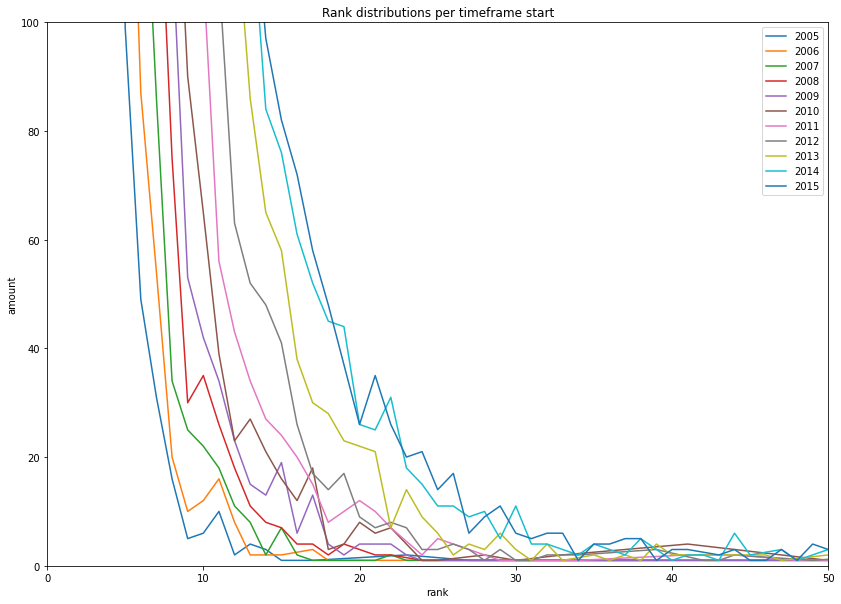

In [ ]:
granularity = 1
y_size = 100
x_size = 50
i = 0
ax = plt.gca()
for key in timeframes.keys():
  sr = pd.concat([authors_df.authors_parsed.loc[timeframes[key]].explode(), social_rank_df.iloc[timeframes[key], 1+i].explode()], axis=1).groupby(by='authors_parsed').first().iloc[:,0]
  pd.DataFrame(((sr*granularity).round(0)/granularity).value_counts()) \
    .reset_index().sort_values(by='index',ascending=False) \
    .plot(x='index', y=1,ylabel='amount',xlabel='rank',xlim=(0,x_size), ylim=(0,y_size), figsize=(14, 10), ax=ax)
  i+=1

plt.title('Rank distributions per timeframe start')
plt.show()

#### Paper score with incoming citations

Aim is to find two seperate metrics to measure importance. They're each based on:
*   A ranking, where the ranking is based on incoming citations, and then if there are any ties then year.
*   Simply the number of incoming citations.


We find a z-score coming directly from inbound citations.

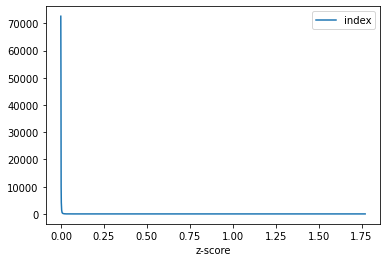

In [ ]:
import statistics

def z_score_citations(df):
  in_citations_mean = statistics.mean(df['in_citations'])
  in_citations_var = statistics.variance(df['in_citations'])

  return df[['id', 'in_citations']].set_index('id') \
    .apply(lambda x: (x - in_citations_mean) / in_citations_var) \
    .rename(columns={'in_citations':'z-score'})

plt_ = z_score_citations(citations_df).reset_index(drop=True)
plt_ = plt_[plt_['z-score'] * 10000 > -7]
plt_.round(3).reset_index().groupby(by='z-score').count().plot()

For the ranking, we begin by defining the ranking

In [ ]:
def rank_citations(df):
  ranked_df = df \
    .groupby(by='in_citations', as_index=False) \
    .agg({'id': lambda x: x.tolist()}) \
    .sort_values(by='in_citations', ascending=False) \
    .reset_index(drop=True)
  ranked_df.index += 1
  ranked_df = ranked_df.reset_index().explode('id') \
    .rename(columns={'index':'rank'}).reset_index(drop=True)[['id','in_citations','rank']]
  return ranked_df

In [ ]:
rank_citations(citations_df) # we will operate over several subsets of citations_df

,id,in_citations,rank
0,1512.03385,30469,1
1,1409.1556,24940,2
2,1409.4842,12131,3
3,1310.4546,12057,4
4,1502.03167,11921,5
...,...,...,...
223798,1911.10515,0,854
223799,1911.10485,0,854
223800,2004.01167,0,854
223801,2004.00819,0,854


Use the ranking to create a percentile. Then, using the percentile we can easily find a z-score based on the ranking.

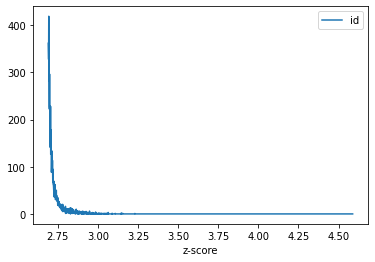

In [ ]:
from scipy.stats import norm

def z_score(df):
  return df[['id','rank']].set_index('id') \
    .apply(lambda x: 1 - ((x - 0.5) / df.shape[0])) \
    .apply(norm.ppf).rename(columns={'rank':'z-score'})

plt_ = z_score(rank_citations(citations_df))
plt_ = plt_[plt_['z-score'] > 2.69]
plt_.round(3).reset_index().groupby(by='z-score').count().plot()

The most important paper is an article on deep learning, makes sense!

In [ ]:
most_important_paper_id = z_score(rank_citations(citations_df)).reset_index().iloc[0]['id']
most_important_paper = words_df[words_df['id'] == most_important_paper_id][['title', 'abstract']].reset_index(drop=True).iloc[0]

print(f"Title:\n{most_important_paper['title']}\n\nAbstract:\n{most_important_paper['abstract']}")

Title:
Deep Residual Learning for Image Recognition

Abstract:
  Deeper neural networks are more difficult to train. We present a residual
learning framework to ease the training of networks that are substantially
deeper than those used previously. We explicitly reformulate the layers as
learning residual functions with reference to the layer inputs, instead of
learning unreferenced functions. We provide comprehensive empirical evidence
showing that these residual networks are easier to optimize, and can gain
accuracy from considerably increased depth. On the ImageNet dataset we evaluate
residual nets with a depth of up to 152 layers---8x deeper than VGG nets but
still having lower complexity. An ensemble of these residual nets achieves
3.57% error on the ImageNet test set. This result won the 1st place on the
ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100
and 1000 layers.
  The depth of representations is of central importance for many visual
recognitio

Now, let's get a dictionary of dataframes by timeframe window to combine with the author rankings

In [ ]:
citation_score = {}
for key in timeframes.keys():
  citation_score[key] = z_score(rank_citations(citations_df.loc[timeframes[key]]))

In [ ]:
citation_score[2005]

,z-score
id,
math/0502327,3.888716
cs/0510071,3.613297
1009.0516,3.478685
1010.3003,3.387459
cs/0205028,3.317896
...,...
cs/0505088,1.906886
1011.0218,1.906886
1004.0838,1.906886


#### Keywords

Next we'll find the words each paper uses (along with the counts). For this, we'll assume that the abstract is representative of the entire paper. Importantly, we're only interested in nouns (of all types) and verbs (again, of all types). The process for each abstract will be:
1.   Remove stopwords.
2.   Get rid of plurals.
3.   Count how many times each word occurred.
4.   Filter out and non-nouns and non-verbs.
5.   Reformat to store as a huge `.json`.

In [ ]:
INTERESTING_WORD_TYPES = set((
  'NN',
  'NNS',
  'NNP',
  'NNPS',
  'VB',
  'VBG',
  'VBD',
  'VBN',
  'VBP',
  'VBZ',
))

# Resources needed for NLTK to run
NLTK_RESOURCES = (
  'stopwords',
  'punkt',
  'averaged_perceptron_tagger',
  'wordnet',
  'omw-1.4',
)

This section of the notebook takes a little bit less than an hour to run, to speed up the notebook runtime we have saved results for the parameters we set and not executed the costly cells

In [ ]:
%%script echo word processing cell, skipping for runnability, delete this line to run
# Setup for the tokeniser
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

for item in NLTK_RESOURCES:
  nltk.download(item)
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

word processing cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo word processing cell, skipping for runnability, delete this line to run
def process_abstract(abstract):
  tokens = tuple(filter(
    lambda word: word not in stopwords,
    nltk.word_tokenize(abstract.lower()),
  ))

  tokens = tuple(map(
    lambda word: lemmatizer.lemmatize(word),
    tokens,
  ))

  word_counter = Counter(nltk.pos_tag(tokens))

  return {
    word: word_count
    for (word, word_type), word_count in word_counter.most_common()
    if word_type in INTERESTING_WORD_TYPES
  }

word processing cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo word processing cell, skipping for runnability, delete this line to run
abstract_word_counts = {
    row[1]['id']: process_abstract(row[1]['abstract'])
    for row in words_df.iterrows()
}
abstract_word_counts

word processing cell, skipping for runnability, delete this line to run


In [ ]:
%%script echo word processing cell, skipping for runnability, delete this line to run
with open('/content/drive/MyDrive/abstract-word-counts.json', 'w') as f_out:
  json.dump(abstract_word_counts, f_out)

word processing cell, skipping for runnability, delete this line to run


Now that we've got a json that contains the word counts, we need to be able to load it into the desired format. The desired schema is:

```
| paper_id (str) | word (str) | count (int) |
```

In [ ]:
# Load the file from drive
with open(f"/content/drive/MyDrive/{GOOGLE_DRIVE_FILE_PATH}/abstract-word-counts.json", 'r') as f:
  abstract_word_counts = json.load(f)
abstract_word_counts

{'1908.05544': {'data': 4,
  'order': 3,
  'preference': 3,
  'approach': 3,
  'system': 2,
  'device': 2,
  'context': 2,
  'exchanging': 2,
  'item': 2,
  'benefit': 2,
  'information': 2,
  'connection': 2,
  'computing': 1,
  'employ': 1,
  'distributed': 1,
  'raise': 1,
  'communicate': 1,
  'process': 1,
  'fashion': 1,
  'smartphone': 1,
  'proliferation': 1,
  'growing': 1,
  'computation': 1,
  'power': 1,
  'wireless': 1,
  'networking': 1,
  'capability': 1,
  'revisit': 1,
  'implementation': 1,
  'digitalized': 1,
  'suggests': 1,
  'smartphones': 1,
  'offline': 1,
  'proximity': 1,
  'collecting': 1,
  'way': 1,
  'allows': 1,
  'attach': 1,
  'instance': 1,
  'enrich': 1,
  'collected': 1,
  '%': 1,
  'recommendation': 1,
  'model': 1,
  'building': 1,
  'require': 1,
  'network': 1,
  'connectivity': 1,
  'privacy': 1,
  'scarcity': 1,
  'issue': 1,
  'address': 1,
  'propagate': 1,
  'filter': 1,
  'method': 1,
  'translates': 1,
  'finding': 1,
  'peer': 1,
  'field

Reformat into the previously discussed schema and load into a dataframe.

In [ ]:
word_occs_df = pd.DataFrame([
  {
    'paper_id': paper_id,
    'word': word,
    'count': count,
  }
  for paper_id, paper_word_count in abstract_word_counts.items()
  for word, count in paper_word_count.items()
])
word_occs_df

,paper_id,word,count
0,1908.05544,data,4
1,1908.05544,order,3
2,1908.05544,preference,3
3,1908.05544,approach,3
4,1908.05544,system,2
...,...,...,...
10368717,1709.03891,switch,1
10368718,1709.03891,wind,1
10368719,1709.03891,direction,1
10368720,1709.03891,equator,1


In [ ]:
# Useful methods
def get_total_word_counts(word_occs_df):
  return word_occs_df[['word', 'count']].groupby('word', as_index=False).sum().sort_values('count', ascending=False).reset_index(drop=True)

def get_num_papers_word_present_in(word_occs_df):
  return word_occs_df[['word', 'count']].groupby('word', as_index=False).count().sort_values('count', ascending=False).reset_index(drop=True)

def get_word_paper_ratios(word_occs_df):
  word_paper_ratios = get_num_papers_word_present_in(word_occs_df)
  word_paper_ratios['count'] = word_paper_ratios['count'] * 100 / word_paper_ratios.shape[0]
  return word_paper_ratios.rename({'count': 'ratio'}, axis=1)

What's our distribution of words like? I.e., how many words occur in less than 1% of papers?

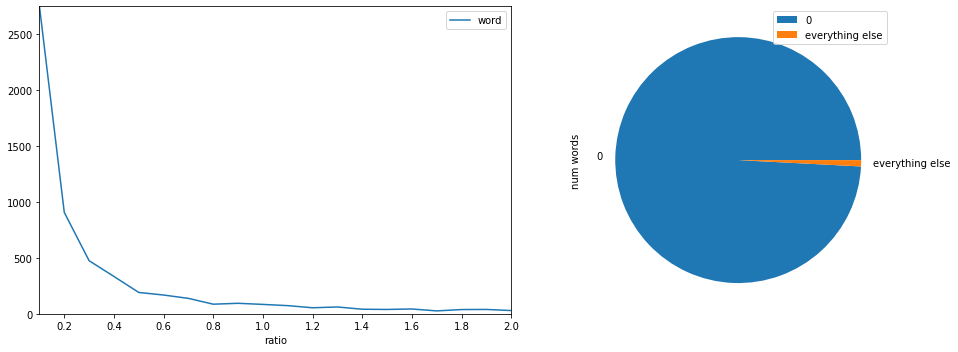

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

word_ratios_df = get_word_paper_ratios(word_occs_df)
word_ratios_df['ratio'] = word_ratios_df['ratio'].apply(lambda x: round(x, 1))
word_ratios_df = word_ratios_df.groupby('ratio', as_index=False).count()
word_ratios_df = word_ratios_df[word_ratios_df['ratio'] > 0].set_index('ratio')
word_ratios_df.plot(ylim=(0, max(word_ratios_df['word'])), xlim=(0.1, 2), xticks=[i / 5 for i in range(11)], ax=axes[0])

word_ratios_df = get_word_paper_ratios(word_occs_df)
word_ratios_df['ratio'] = word_ratios_df['ratio'].apply(round)
word_ratios_df = word_ratios_df.groupby('ratio', as_index=False).count().rename({'word': 'num_words'}, axis=1)

non_zero_df = word_ratios_df[word_ratios_df['ratio'] > 0]
zero_df = word_ratios_df[word_ratios_df['ratio'] == 0]
pie_df = pd.DataFrame([
  {
    'ratio': '0',
    'num words': zero_df.iloc[0]['num_words']
  }, {
    'ratio': 'everything else',
    'num words': sum(non_zero_df['num_words'])
  },
]).set_index('ratio')
pie_df.plot(x='ratio', y='num words', kind='pie', ax=axes[1])

fig.tight_layout()
plt.show()

It turns out that only an extraordinarily small fraction of words are present in more than 1% of papers...

There are however a few words that occur in *most* papers. Thus, remove them from the dataframe. This should only be a very small subset of ~15 out of 100k+ words.

In [ ]:
# Words that occur in most papers are useless to us, so we'll remove them

WORD_REMOVAL_THRESHOLD = 30

def filter_commonly_present_words(word_occs_df, debug=False):
  words_paper_ratios = get_word_paper_ratios(word_occs_df)
  if(debug): print(words_paper_ratios)
  words_to_remove_series = words_paper_ratios[words_paper_ratios['ratio'] > WORD_REMOVAL_THRESHOLD]['word']
  words_to_remove_set = set(words_to_remove_series)
  if(debug): print(f"Removing words in {words_to_remove_set}")
  return word_occs_df[word_occs_df['word'].apply(lambda word: word not in words_to_remove_set)]

In [ ]:
# Filter the original df
_ = filter_commonly_present_words(word_occs_df, debug=True)

                          word      ratio
0                        paper  52.256900
1                       result  42.779392
2                         show  40.787011
3                        model  38.296027
4                      problem  37.193826
...                        ...        ...
197146         matching-filter   0.000507
197147    matching-equilibrium   0.000507
197148  matching-decyclability   0.000507
197149         matching-bounds   0.000507
197150          âcohesionâ   0.000507

[197151 rows x 2 columns]
Removing words in {'based', 'using', 'paper', 'problem', 'model', 'approach', 'system', 'result', 'data', 'network', 'show', 'method'}


By removing these words, we need to make sure that we haven't just gotten rid of our entire dataset. Thus, graph the number of words per paper before and after the commonly occurring words have been removed.

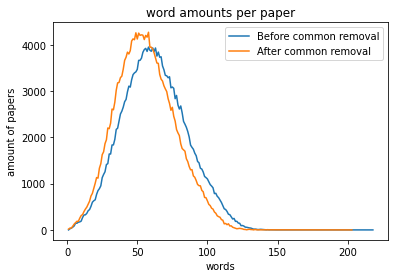

In [ ]:
def num_words(df):
  return {
    row['paper_id']: row['count']
    for _, row in df.groupby('paper_id', as_index=False).sum()[['paper_id', 'count']].iterrows()
  }

ax = plt.gca()
pd.DataFrame.from_dict(num_words(word_occs_df), orient='index').reset_index().groupby(by=0, as_index=True).count().rename(columns={'index':'Before common removal'}).plot(xlabel='words', ylabel='amount of papers',title='word amounts per paper',ax=ax)
pd.DataFrame.from_dict(num_words(filter_commonly_present_words(word_occs_df)), orient='index').reset_index().groupby(by=0, as_index=True).count().rename(columns={'index':'After common removal'}).plot(xlabel='words', ylabel='amount of papers',title='word amounts per paper',ax=ax)

As you can see, even though these words are present in most papers the number of words per paper hasn't dropped significantly, which is good!

#### Combining features

We might have outliers, we add a `_` as empty word, they will get removed anyway, but will mess up our indexes if they don't exist

In [ ]:
for outlier_id in set(social_rank_df['id'].values).difference(set(word_occs_df['paper_id'].values)):
  outlier = words_df[words_df['id'] == outlier_id][['title', 'abstract']].reset_index(drop=True).head(1)

  print(f"Title:\n{outlier['title']}\n\nAbstract:\n{outlier['abstract']}")

Title:
0    Do we have privacy in the digital world?
Name: title, dtype: object

Abstract:
0      Not really.\n
Name: abstract, dtype: object


**Sidenote**: This above paper is dumb and I love it. It did however cause a rediculous amount of pain.

In [ ]:
for key in timeframes.keys():
  for outlier_id in set(citation_score[key].index).difference(set(word_occs_df['paper_id'].values)):
    word_occs_df.loc[len(word_occs_df.index)] = [outlier_id,'_', 1]

Word counts for a paper are very variable, and more than 3 occurances are not indicative of more imporance in the paper, we can apply a log score to normalize these into a more reasonable distribution.

In [ ]:
word_occs_df['count'] = word_occs_df['count'].apply(lambda x: math.log(x+1))

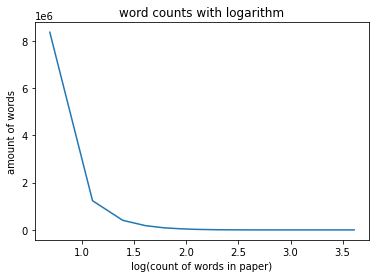

In [ ]:
word_occs_df['count'].round(2).reset_index().groupby(by='count').count().plot(legend=False,xlabel='log(count of words in paper)',ylabel='amount of words', title='word counts with logarithm')

Now, we have to join the 3 metrics `[word-count, citation-score, author-score]` to get a final score per word, we will use the equation `score = word-count * (citation-score + author-score)`, this score will be generated for each word in a paper, and we will join them by adding up the scores for a given word over all papers.

We save these results in `timeframe_scores`

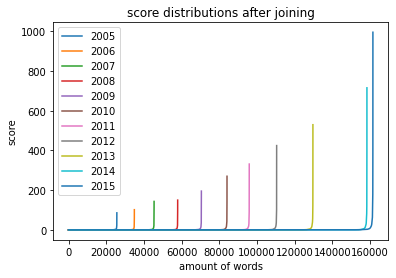

In [ ]:
ax = plt.gca()
timeframe_scores = {}
for key in timeframes.keys():
  time_partition_df = word_occs_df.set_index('paper_id').loc[words_df['id'].loc[timeframes[key]].values] \
    .join(citation_score[key]) \
    .join( \
      social_rank_df[['id',str(key)]].loc[timeframes[key]].set_index('id').squeeze() \
      .apply(lambda x: (x[0] + (max(x[1:]) if len(x) > 1 else x[0]))/2).rename('author-score'))
  scaled_scores_df = pd.DataFrame(MinMaxScaler().fit_transform(time_partition_df[['z-score', 'author-score']]), index=time_partition_df.index)
  time_partition_df['z-score'] = scaled_scores_df[0]
  time_partition_df['author-score'] = scaled_scores_df[1]
  time_partition_df['score'] = time_partition_df['count'] * (time_partition_df['z-score'] + time_partition_df['author-score'])
  time_partition_df['score']  -= time_partition_df['score'].min()
  time_partition_df['score'] /= time_partition_df['score'].max()
  # time_partition_df['score'].sort_values().reset_index(drop=True).plot(title='score distributions before joining',xlabel='amount of words', ylabel='score')
  time_partition_df = time_partition_df[['word','score']].groupby(by='word').sum()
  time_partition_df.sort_values(by='score').reset_index(drop=True).rename(columns={'score':key}).plot(title='score distributions after joining',xlabel='amount of words', ylabel='score', ax=ax)
  timeframe_scores[key] = time_partition_df

### Making predictions

#### Cleaning scores

Graph the cumulative amount of unique words (y) against the timeframe number (x).

(0.0, 176180.72727272726)

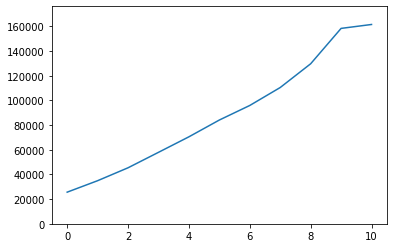

In [ ]:
amounts_per_timeframe = []
for key in timeframe_scores:
  amounts_per_timeframe.append(timeframe_scores[key].shape[0])

fig, ax = plt.subplots()
ax.plot(amounts_per_timeframe)
ax.set_ylim(0,max(amounts_per_timeframe) + max(amounts_per_timeframe)/len(amounts_per_timeframe))

In [ ]:
def tfs_counts():
  counts = []
  for key in timeframe_scores:
    counts.append(str(timeframe_scores[key].shape[0]))
  return '['+', '.join(counts) + ']'

In [ ]:
print(tfs_counts())

[25635, 34920, 45387, 57907, 70485, 84086, 95887, 110427, 129667, 158330, 161499]


Single quotes do not usually denote meaning, our word parser consideres them as part of a word, we can join them

In [ ]:
for key in timeframe_scores:
  op = timeframe_scores[key].reset_index()

  op.word = op.word.apply(lambda x:x.replace('\'',''))
  op = op.groupby(by='word').sum()

  timeframe_scores[key] = op

Basic mathematical symbols `['+','-','/','*','^']` usually come from part of mathematical expressions and do not convey meaning

In [ ]:
import re

for key in timeframe_scores:
  op = timeframe_scores[key].reset_index()

  op.word = op.word.apply(lambda x: re.sub('[+-/*^]', '', x))

  timeframe_scores[key] = op.set_index('word')

Words or symbols with less than 2 characters do not usually denote meaning (exceptions exist, example: `'l2'` from _l2 regularization_, despite this, our model would still distinguish `'regularization'`)

In [ ]:
for key in timeframe_scores:
  op = timeframe_scores[key].reset_index()

  op = op[op['word'].apply(len) > 2]

  timeframe_scores[key] = op.set_index('word')

In [ ]:
print(tfs_counts())

[24578, 33515, 43717, 55876, 68140, 81413, 93053, 107374, 126305, 154588, 157767]


Numbers do not convey meaning by themselves, remove them

In [ ]:
for key in timeframe_scores:
  op = timeframe_scores[key].reset_index()

  op = op[op['word'].apply(lambda x: not x.isnumeric())]

  timeframe_scores[key] = op.set_index('word')

In [ ]:
print(tfs_counts())

[24572, 33504, 43690, 55842, 68095, 81357, 92983, 107288, 126174, 154388, 157553]


Final step, regrup words again to join any newly created pairs

In [ ]:
for key in timeframe_scores:
  op = timeframe_scores[key].reset_index()

  op = op.groupby(by='word').sum()

  timeframe_scores[key] = op

In [ ]:
print(tfs_counts())

[23936, 32430, 42116, 53662, 65234, 77682, 88662, 102178, 120004, 146666, 149735]


#### Finding common words

We'll define a common word as a word existing in 3 or more timeframes

In [ ]:
all_words = pd.DataFrame()
for key in timeframe_scores:
  all_words = pd.concat([all_words, timeframe_scores[key]])
print('Total words through all timeframes: '+str(all_words.shape[0]))

Total words through all timeframes: 902305


In [ ]:
repeated_words = all_words.reset_index().groupby(by='word').count().sort_values(by='score')
repeated_words = repeated_words[repeated_words.score > 2].reset_index()
print('Common words through all timeframes: '+str(repeated_words.shape[0]))

Common words through all timeframes: 134681


Non-cumulative word count by window.

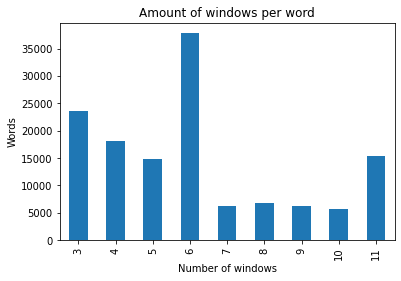

In [ ]:
repeated_words['score'].value_counts().reset_index().sort_values(by='index').set_index('index').plot(kind='bar',title='Amount of windows per word', xlabel='Number of windows', ylabel='Words', legend=False)

Finally, we have our features

In [ ]:
features_df = repeated_words[['word']].set_index('word')
for key in timeframe_scores:
  features_df = features_df.join(timeframe_scores[key].rename(columns={'score':key}))
features_df = features_df.fillna(0)

In [ ]:
features_df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
word,,,,,,,,,,,
\tau_\mathsf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003024,0.002730,0.003625
instancesegmentation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019115,0.018278,0.027471
foruser,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001158,0.001043,0.001365
foverlay,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002556,0.002263,0.002344
forwardpropagation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002804,0.018187,0.033308
...,...,...,...,...,...,...,...,...,...,...,...
appended,0.019369,0.017776,0.022377,0.011469,0.009421,0.011317,0.017110,0.059479,0.136042,0.239874,0.417801
hyperspheres,0.039035,0.026109,0.021269,0.020240,0.023467,0.049493,0.067263,0.081288,0.091398,0.091708,0.118378
conquer,0.010401,0.114197,0.219679,0.264324,0.270432,0.362934,0.479006,0.459223,0.454090,0.475236,0.699151


#### Final preprocessing

Now  we have everything we need!

With all of the features we have created from our analysis, we are going to predict what words are going to popular in future years.

In [ ]:
features_with_words = pd.DataFrame(features_df)

In [ ]:
features_df = features_df.reset_index(drop=True)

We have time series data, however not all of it follows the same distribution. In order to better fit into the model we will try and filter the distribution and group them which'll allow us to generate predictions for a specific distribution.

In [ ]:
features_df = features_df.loc[~(features_df==0).all(axis=1)]

In [ ]:
distributions_df = pd.DataFrame(index=features_df.index)
for col in features_df.columns:
  distributions_df[col] = features_df[col].apply(lambda x: 0 if x == 0 else 1)
distributions_df['encoded'] = distributions_df.apply(lambda row : ''.join(map(str,row)), axis = 1)
distributions_df = distributions_df[['encoded']].reset_index().reset_index().groupby(by='encoded', as_index=False).agg({'index': lambda x: x.tolist(), 'level_0':'count'}).rename(columns={'index':'index_list', 'level_0':'size'}).sort_values(by='size',ascending=False)

Let's filter the highest distributions for our predictions

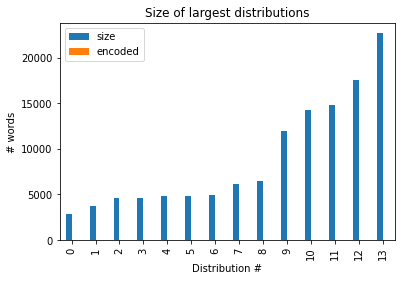

In [ ]:
top_dist_df = distributions_df[distributions_df['size'] > 1000]
top_dist_df[['encoded','size']].groupby(by='size', as_index=False).count().plot(kind='bar', title='Size of largest distributions', xlabel='Distribution #', ylabel='# words')

Make a small scale prediction over our largest distribution.

In [ ]:
test_df = features_df.loc[top_dist_df.iloc[0,1]].iloc[:,-3:]

In [ ]:
train_df = features_df.loc[top_dist_df.iloc[1,1]].iloc[:,-4:]

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
predictions = model.fit(train_df.values[:,:-1], train_df.values[:,-1:]).predict(test_df.values)

In [ ]:
test_df['2016_pred'] = predictions

And our result is...

In [ ]:
features_with_words.reset_index().loc[top_dist_df.iloc[0,1][test_df.sort_values(by='2016_pred', ascending=False).reset_index().iloc[0,0]]].iloc[0]

'allfocus'

We don't know what allfocus is :'(

In order to predict over all of our data we have to relate distributions between each other. One way to do this is finding all distributions with a tail in the last timeframe and sorting them from largest to smallest.

The longest distribution fits a model that predicts the next timeframes results, which will be the second longest. In turn, the second longest will predicst the third longest and so on.

In [ ]:
top_dist_df['end_0'] = top_dist_df['encoded'].apply(lambda x: x[-1:])
tail_dists = top_dist_df[top_dist_df['end_0'] == '1'].sort_values(by='encoded',ascending=False).reset_index(drop=True)
tail_dists

,encoded,index_list,size,end_0
0,11111111111,"[119307, 119308, 119309, 119310, 119311, 11931...",14820,1
1,01111111111,"[113572, 113573, 113574, 113575, 113576, 11357...",4612,1
2,00111111111,"[107356, 107357, 107358, 107359, 107360, 10736...",4796,1
3,00011111111,"[100580, 100582, 100583, 100584, 100586, 10058...",4929,1
4,00001111111,"[94434, 94435, 94436, 94437, 94438, 94440, 944...",4571,1
5,00000111111,"[56595, 56598, 56603, 56604, 56607, 56610, 566...",11926,1
6,00000011111,"[41744, 41745, 41746, 41747, 41748, 41749, 417...",14233,1
7,00000001111,"[23605, 23606, 23607, 23608, 23609, 23610, 236...",17533,1
8,00000000111,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",22715,1


In [ ]:
col_num = len(features_df.columns)
predictions_df = pd.DataFrame(columns=[0])
current_distribution_df = features_df.loc[tail_dists['index_list'][0]]
model = LinearRegression().fit(features_df.loc[tail_dists['index_list'][0]].iloc[:,-col_num+0:-1].values, features_df.loc[tail_dists['index_list'][0]].iloc[:,-1:].values)

for i in range(1, col_num-2):
  predictions = model.predict(features_df.loc[tail_dists['index_list'][i]].iloc[:,i:].values)
  predictions_df = pd.concat([predictions_df, pd.DataFrame(data=predictions,index=tail_dists.iloc[i,1])])
  model = LinearRegression().fit(features_df.loc[tail_dists['index_list'][i]].iloc[:,-col_num+i:-1].values, features_df.loc[tail_dists['index_list'][i]].iloc[:,-1:].values)

And let's get the full list of ranked predicts, from highest predicted importance.

In [ ]:
future_trends = features_with_words.reset_index().loc[predictions_df.sort_values(by=0, ascending=False).reset_index()['index']]['word']
future_trends

104198           cnns
112976       imagenet
117215    autoencoder
48979            gans
103552           lstm
             ...     
104565        wetware
79064          itunes
108636        codyrun
106888           nade
99269           nades
Name: word, Length: 85315, dtype: object

In [ ]:
future_trends[0:20]

104198                cnns
112976            imagenet
117215         autoencoder
48979                 gans
103552                lstm
114923                dnns
94699                  gan
98294           blockchain
117702             caption
97032                 coco
112779          captioning
114228              mmwave
107118                noma
118532                 voc
116444    reidentification
116473            ablation
110951             dropout
104990               drone
113293               kitti
61276                  vqa
Name: word, dtype: object

Success!!! Our top, most important words are what we would've expected, which is great!

Let's make a word cloud to visualize our results

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
word_dict = {}

for i in range(200):
  word_dict[str(future_trends.reset_index(drop=True)[i])] = predictions[1][0]

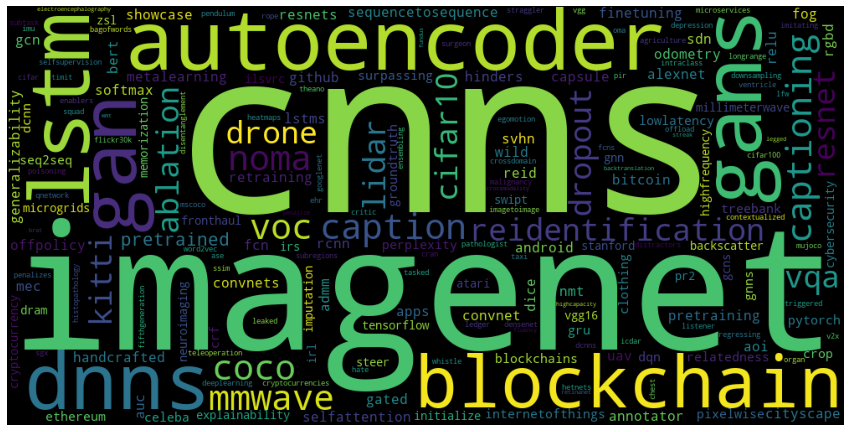

In [ ]:
from collections import Counter
from wordcloud import WordCloud

word_could_dict=Counter(word_dict)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Conclusions

We're very satisfied with the result we've found, as it seems extremely reasonable and is exactly what we set out to do.





---


## Improvements, Learnings and Potential Next Steps

We'd originally intended to create more models to predict other quantities, but we've unfortunately run out of time. We simply did too much analysis before getting into prediction. There are a few things that we could certainly have done better:


*   Use a different, more complicated model to make predicitions. Currently we're simply doing a linear model, but if we had more time I'm sure we could make a CNN etc that could do a better job at predicting word importance.
*   In hindsight we should've ditched the kaggle dataset completely and gone with the S2ORC. It's just far more comprehensive and would eliminate the need of 'stitching' the datasets together.
*   The way we've determined word importance is quite arbitritrary. Whilst it seems to have worked quite nicely, it would've been nice to have some basis for why we picked it.

Future work:


*   Using the data collected we could likely easily create a model that predicts paper importance given the abstract.